In [18]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Classes

In [19]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## PCA

In [20]:
class c_PCA :
    def __init__(self, df, columns, n_components=6):
        self.df = df[columns]
        self.columns = columns
        self.n_components = n_components
        self.X = self.df.values 
        self.X_scaled = None
        self.X_scaled_verif = None
        self.pca = None
        self.pcs = None
    
   
    def scale(self,scalertype):
        scaler = scalertype
        scaled_features = scaler.fit(self.X)
        self.X_scaled = scaled_features.transform(self.X)
        self.X_scaled_verif = pd.DataFrame(self.X_scaled).describe().round(2).loc[["mean", "std"], :]
        

    def pca_evr(self):
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(self.X_scaled)
        
        self.pcs = self.pca.components_
        self.pcs = pd.DataFrame(self.pcs, columns=self.columns)
        self.pcs.index = [f"F{i+1}" for i in range(self.n_components)]
        self.pcs = self.pcs.round(2)
        
        evr = (self.pca.explained_variance_ratio_*100).round(2)
        print("Explained variance ratio: ", evr)
        evr_cum = evr.cumsum().round()
        print("Cumulative explained variance ratio: ", evr_cum)
        
        x_list = range(1,self.n_components+1)
        
        plt.bar(x_list, evr)
        plt.plot(x_list, evr_cum,c="red",marker='o')
        plt.xlabel("rang de l'axe d'inertie")
        plt.ylabel("pourcentage d'inertie")
        plt.title("Eboulis des valeurs propres")
        plt.show(block=False)
        

    def correlation_circle(self,
                           ax,
                           x_y) : 
        """Affiche le graphe des correlations

        Positional arguments : 
        -----------------------------------
        pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
        x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
        features : list ou tuple : la liste des features (ie des dimensions) à représenter
        """

        # Extrait x et y 
        x,y=x_y

        # Pour chaque composante : 
        for i in range(0, self.pca.components_.shape[1]):

            # Les flèches
            ax.arrow(0,0, 
                    self.pca.components_[x, i],  
                    self.pca.components_[y, i],  
                    head_width=0.07,
                    head_length=0.07, 
                    width=0.02, )

            # Les labels
            plt.text(self.pca.components_[x, i] + 0.05,
                    self.pca.components_[y, i] + 0.05,
                    self.columns[i])
            
        # Affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # Nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(x+1, round(100*self.pca.explained_variance_ratio_[x],1)))
        plt.ylabel('F{} ({}%)'.format(y+1, round(100*self.pca.explained_variance_ratio_[y],1)))

        # J'ai copié collé le code sans le lire
        plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

        # Le cercle 
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

        # Axes et display
        plt.axis('equal')
        plt.show(block=False)
        
   
    def display_factorial_planesi(self,ax, x_y,
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                marker="." ):
        """
        Affiche la projection des individus

        Positional arguments : 
        -------------------------------------
        X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
        x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

        Optional arguments : 
        -------------------------------------
        pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
        labels : list ou tuple : les labels des individus à projeter, default = None
        clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
        alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
        marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
        """

        X_projected = self.pca.transform(self.X_scaled)
        # Transforme X_projected en np.array
        X_ = np.array(X_projected)

        # On gère les labels
        if  labels is None : 
            labels = []
        try : 
            len(labels)
        except Exception as e : 
            raise e

        # On vérifie la variable axis 
        if not len(x_y) ==2 : 
            raise AttributeError("2 axes sont demandées")   
        if max(x_y )>= X_.shape[1] : 
            raise AttributeError("la variable axis n'est pas bonne")   

        # on définit x et y 
        x, y = x_y

        # On vérifie s'il y a des clusters ou non
        c = None if clusters is None else clusters
    
        # Les points    
        # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
        #                     c=c, cmap="Set1", marker=marker)
        sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())

        # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
        v1 = str(round(100*self.pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*self.pca.explained_variance_ratio_[y]))  + " %"


        # Nom des axes, avec le pourcentage d'inertie expliqué
        ax.set_xlabel(f'F{x+1} {v1}')
        ax.set_ylabel(f'F{y+1} {v2}')

        # Valeur x max et y max
        x_max = np.abs(X_[:, x]).max() *1.1
        y_max = np.abs(X_[:, y]).max() *1.1

        # On borne x et y 
        ax.set_xlim(left=-x_max, right=x_max)
        ax.set_ylim(bottom= -y_max, top=y_max)

        # Affichage des lignes horizontales et verticales
        plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
        plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

        # Affichage des labels des points
        if len(labels) : 
            # j'ai copié collé la fonction sans la lire
            for i,(_x,_y) in enumerate(X_[:,[x,y]]):
                plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

        # Titre et display
        plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
        plt.show()
        
        

## CAH

In [21]:
class CAH :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.Z = None
        self.df_mean_std = None
        self.clusters = None
    
    def scale(self,scalertype : StandardScaler)->None:
        """
        This function scales the data using the scaler type provided as input. 
        We are also creating a short DataFrame with the mean and standard deviation of the scaled data.
        
        Parameters:
            scalertype (StandardScaler) : scaler type to use for scaling the data
        
        Returns:
            None
        """
        #Put values in the scaler, fit and transform
        X = self.df.values
        scaler = scalertype
        scaled_features = scaler.fit(X)
        X_scaled = scaled_features.transform(X)
        #Linkage using ward method
        self.Z = linkage(X_scaled, method='ward')
        # Short DataFrame with mean and std to verify the scaling
        self.df_mean_std = pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]
        
    def dendrogram(self,ax,title='Dendogram',xlabel='Distance',ylabel='Individus',labelsize=5):
        '''This function plots the dendrogram. Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, xlabel, ylabel, labelsize
        '''
        _ = dendrogram(self.Z, ax=ax, labels=self.df.index, orientation = "left")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', which='major', labelsize=labelsize)
        ax.tick_params(axis='y', which='major', labelsize=labelsize)
        
    def cluster(self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the dendogram.
            input: n_clusters
        '''
        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage = "ward")
        clustering_model.fit(self.df.values)
        self.clusters = clustering_model.labels_

## Kmeans

In [22]:
class kmeans :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.clusters = []
            
    def plot_inertia(self,ax,title="Inertia",k_max=10):
        '''This function plots the inertia for each k value, from 2 to k_max. Using the elbow method will help choosing the best k value.
        Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, k_max
            output: plot
        '''
        inertia_list = []
        X = self.df.values
        for k in range(1,k_max):
            kmeans = KMeans(n_clusters=k, n_init='auto')
            
            kmeans.fit(X)
            
            inertia_list.append(kmeans.inertia_)
        ax.set_title(title)
        ax.set_xlabel("n_clusters")
        ax.set_ylabel("inertia")
        ax = plt.plot(range(1,k_max), inertia_list)
        
    def plot_silhouette(self, ax,k_list):
        '''This function plots the silhouette score for each k value, specifiy in k_list. 
        Using the silhouette score will help choosing the best k value.
        '''
        X = self.df.values
        for k in k_list:
            if k < 2:
                print("k must be greater than 1")
            else:
                ax[k-2].set_title("Silhouette plot for k = {}".format(k))
                kmeans = KMeans(n_clusters=k, n_init='auto')
                kmeans.fit(X)
                
                score = silhouette_score(self.df.values, kmeans.labels_)
                print("For n_clusters = {}, silhouette score is {:.3f})".format(k, score))
                
                visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[k-2])
                visualizer.fit(X)

    def kmean_choose (self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the inertia plot.
            Define : clusters
        '''
        X = self.df.values
        
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
        
        kmeans.fit(X)
        
        self.clusters = kmeans.labels_

# Import Dataframe

In [23]:
df_og = pd.read_csv('analysis.csv')
df_og.index = df_og['Zone']
df_og = df_og.drop(columns=['Zone'])
df_og.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Allemagne                  658693.5   
Arabie saoudite            526770.3   
Argentine                  168162.0   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Allemagne                                               15029605.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Allemagne                            1489412000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Allemagne                            1233978000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00     3.514310e+05   
Algérie                              4020.25     1.711582e+05   
Allemagne                           33423.00     3.888327e+06   
Arabie saoudite                      2977.50     7.929668e+05   
Argentine                           17866.00     4.454453e+05   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Allemagne                                             1544.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                           
Afrique du Sud            38820.239                                   5721.0   
Algérie                   31236.431                                   4152.0   
Allemagne                 63787.507                                  12920.0   
Arabie saoudite           28700.362                                   2511.0   
Argentine                 41489.566                                  16050.0   

                   region  
Zone                       
Afrique du Sud     Africa  
Algérie            Africa  
Allemagne          Europe  
Arabie saoudite      Asia  
Argentine        Americas

# Analyse 1 

In [24]:
df = df_og.copy()

In [25]:
region = df['region'].tolist()
df = df.drop(columns=['region'])
columns = df.columns.tolist()
df.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Allemagne                  658693.5   
Arabie saoudite            526770.3   
Argentine                  168162.0   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Allemagne                                               15029605.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Allemagne                            1489412000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Allemagne                            1233978000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00     3.514310e+05   
Algérie                              4020.25     1.711582e+05   
Allemagne                           33423.00     3.888327e+06   
Arabie saoudite                      2977.50     7.929668e+05   
Argentine                           17866.00     4.454453e+05   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Allemagne                                             1544.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  
Zone                                                                          
Afrique du Sud            38820.239                                   5721.0  
Algérie                   31236.431                                   4152.0  
Allemagne                 63787.507                                  12920.0  
Arabie saoudite           28700.362                                   2511.0  
Argentine                 41489.566                                  16050.0

## PCA

Explained variance ratio:  [87.12  5.54  3.71  2.13  0.97  0.3 ]
Cumulative explained variance ratio:  [ 87.  93.  96.  98.  99. 100.]


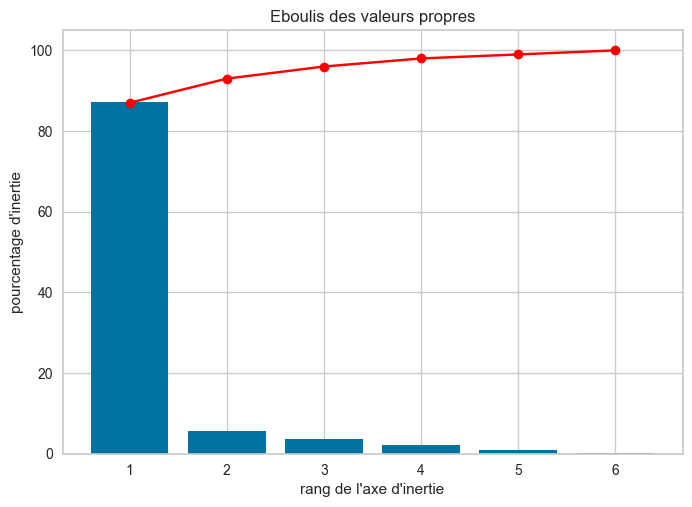

In [26]:
pca = c_PCA(df, columns,6)
pca.scale(StandardScaler())
pca.pca_evr()

Nous avons presque 100% de la variance expliquée par les 4 premiers axes. Nous allons donc nous contenter de les utiliser pour la suite de l'analyse.
On ne peut négliger le fait que 80% de la variance soit éxpliqué par le premier axe.

### Cercles Correlations

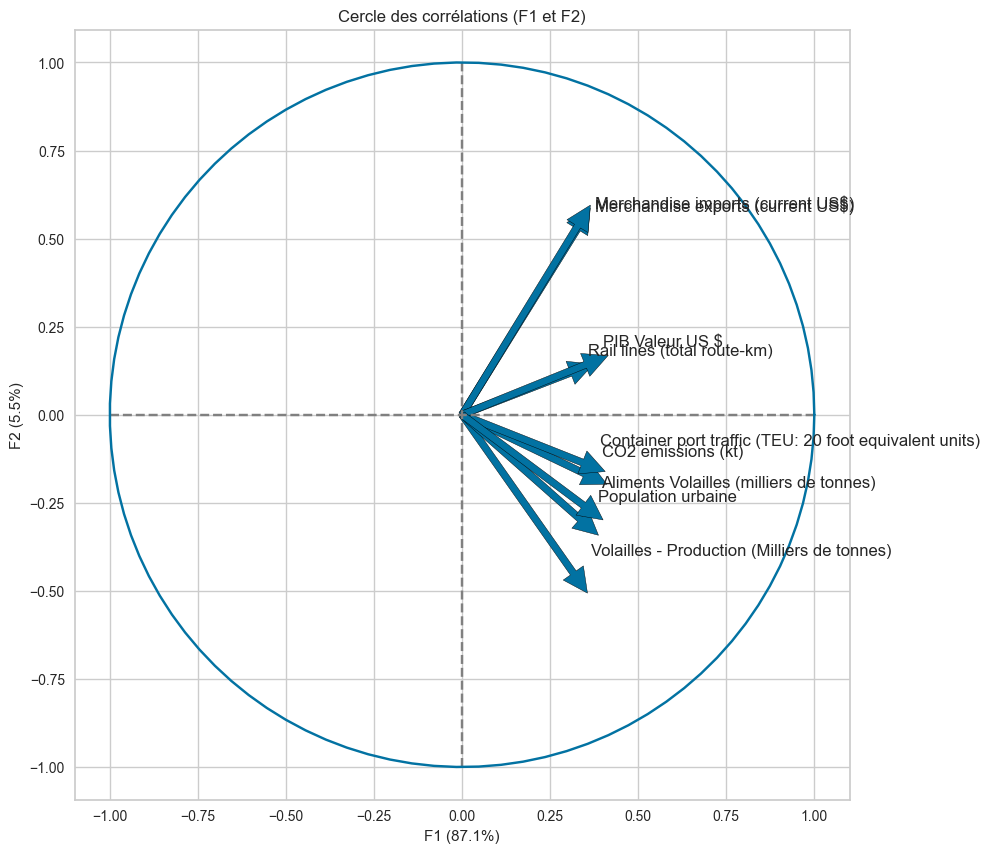

In [27]:
corr1, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,1))

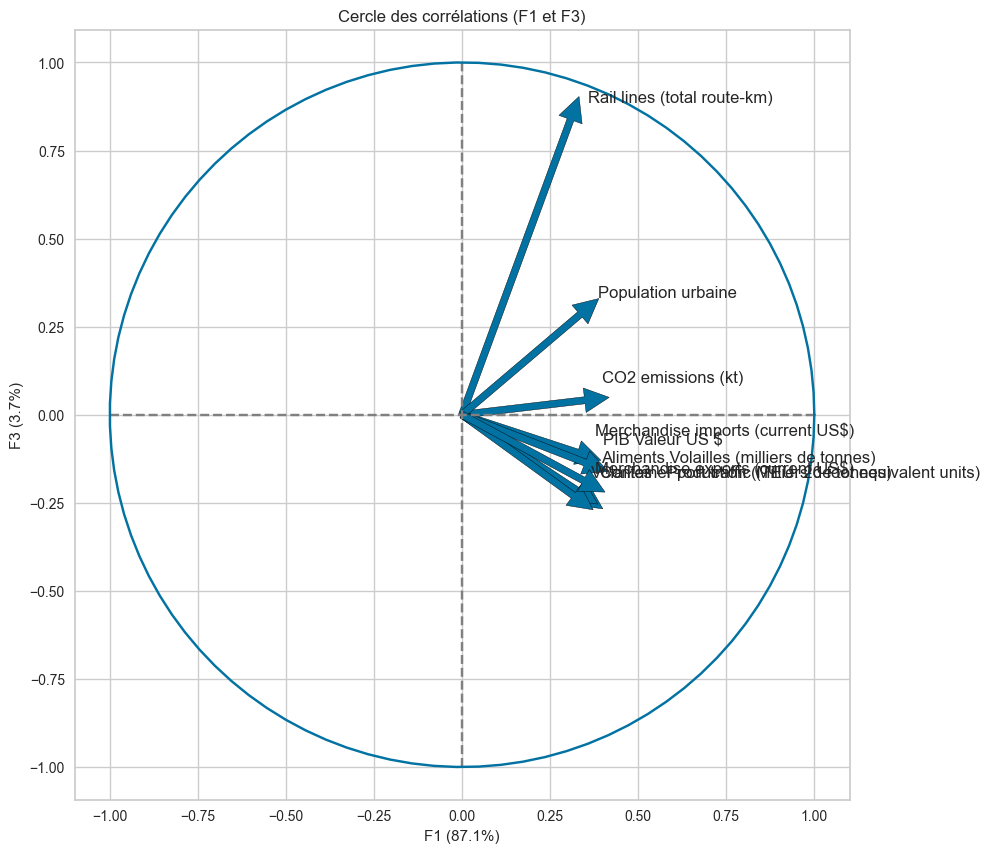

In [28]:
corr2, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,2))

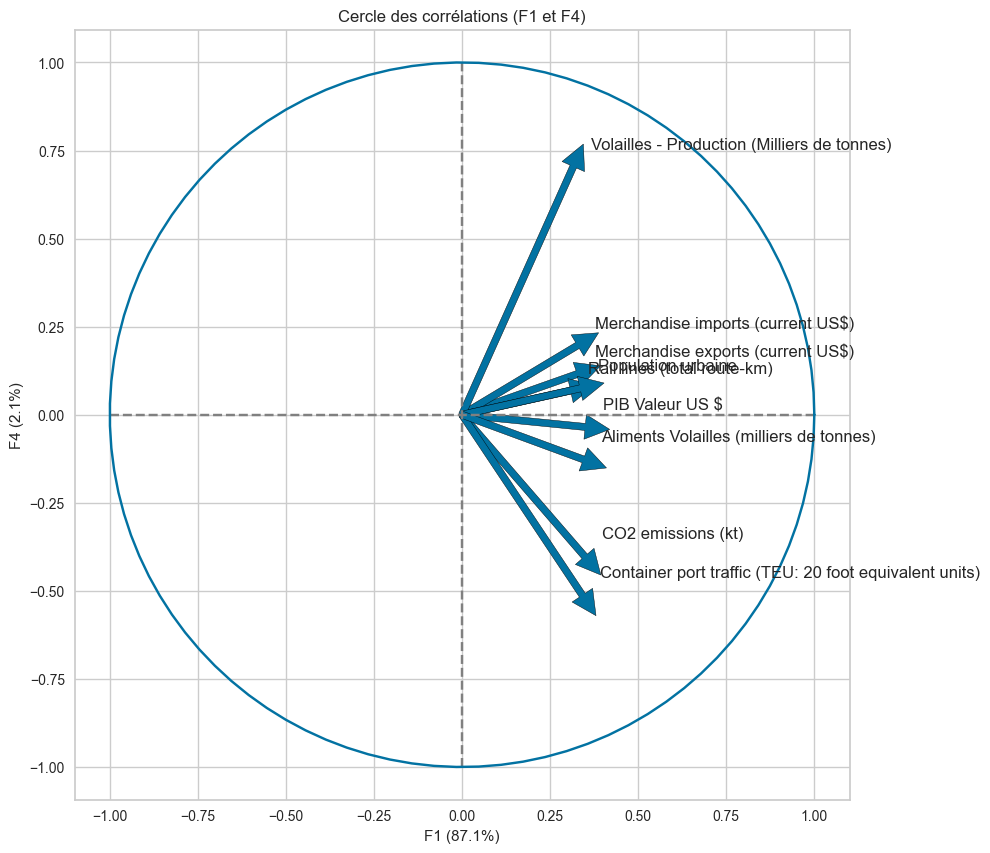

In [29]:
corr3, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,3))

Les variables ne se départagent pas sur F1, ce qui nous empêche de bien pouvoir l'intérpréter correctement.

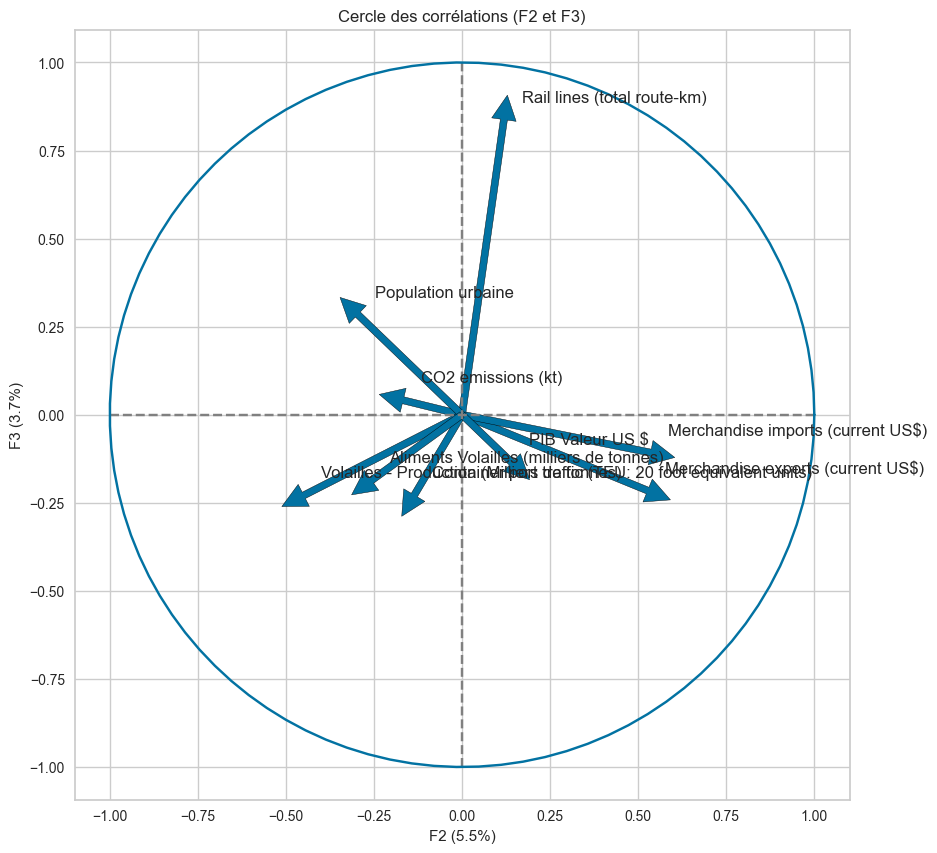

In [30]:
corr4, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (1,2))

F3 est très fortement corrélé au réseau féroviaire. Sur F2, on peut remarquer les variables d'import/export d'un côté (~0.5) et mes variables ed production de volaiile de l'autre (~0.5).

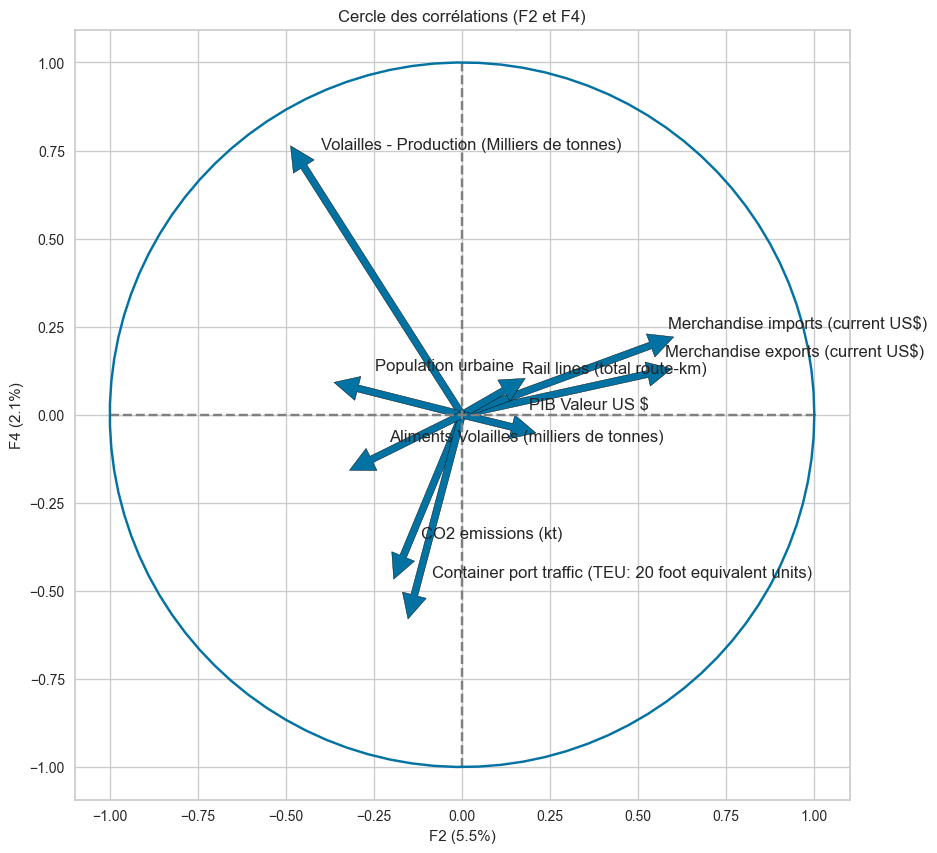

In [31]:
corr5, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (1,3))

Sur F4, nous remarquons un lien fort avec la production de volaille. On y remarque aussi un lien avec le transport maritime et les emission de CO2

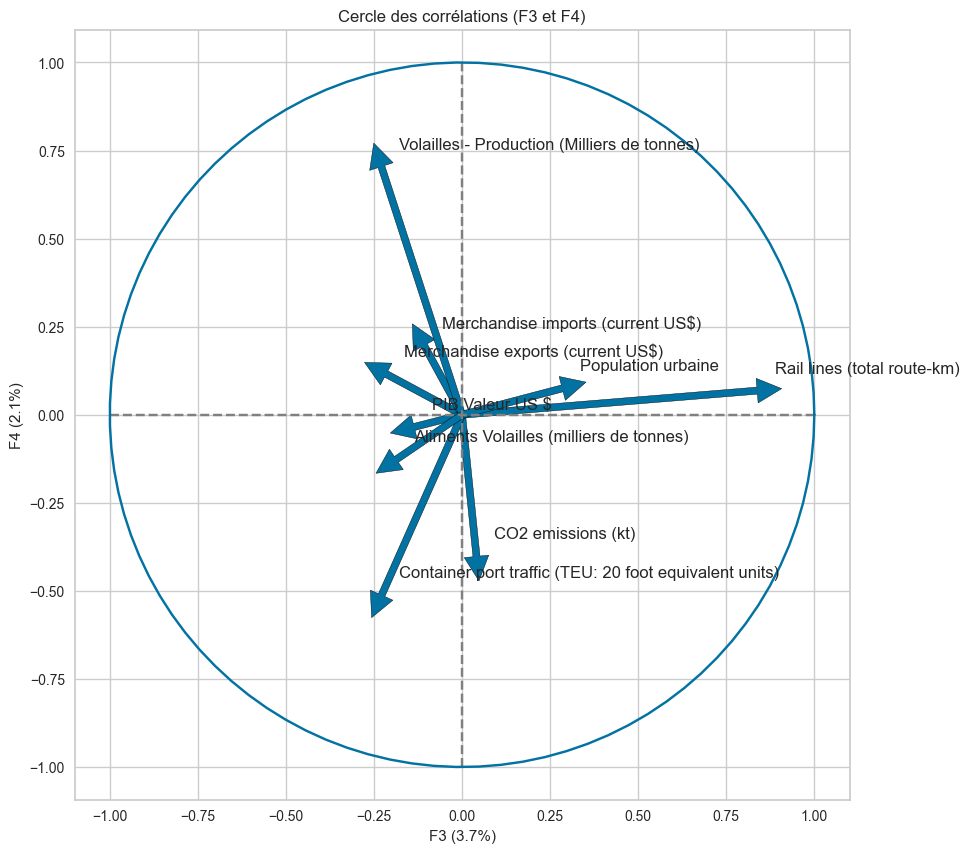

In [32]:
corr6, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (2,3))

### Projection des individus

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


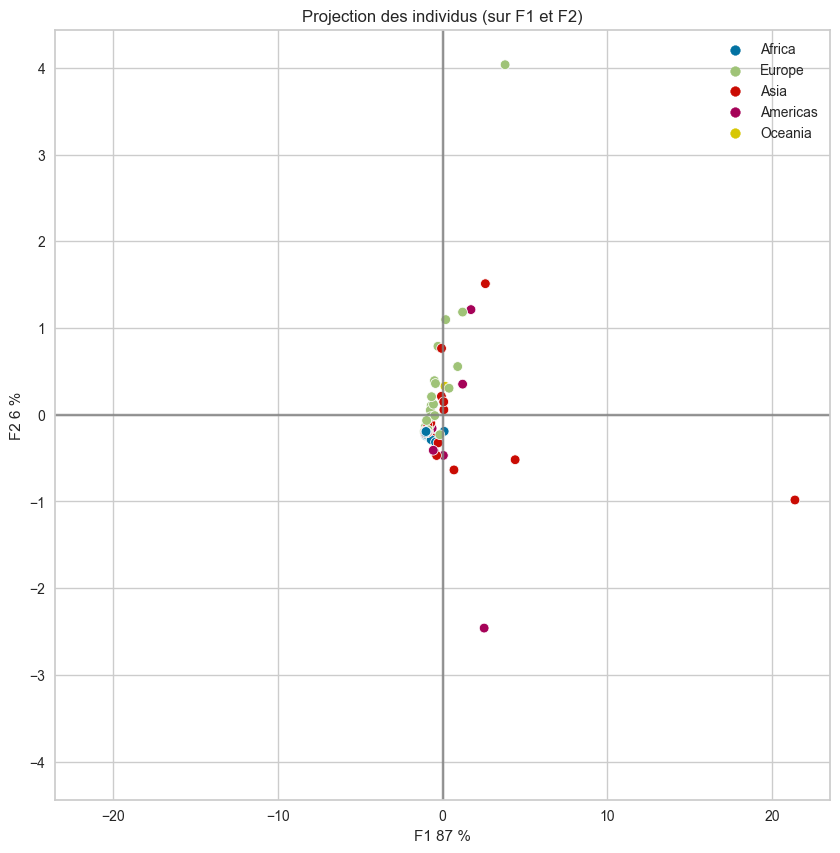

In [33]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,1), clusters=region)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


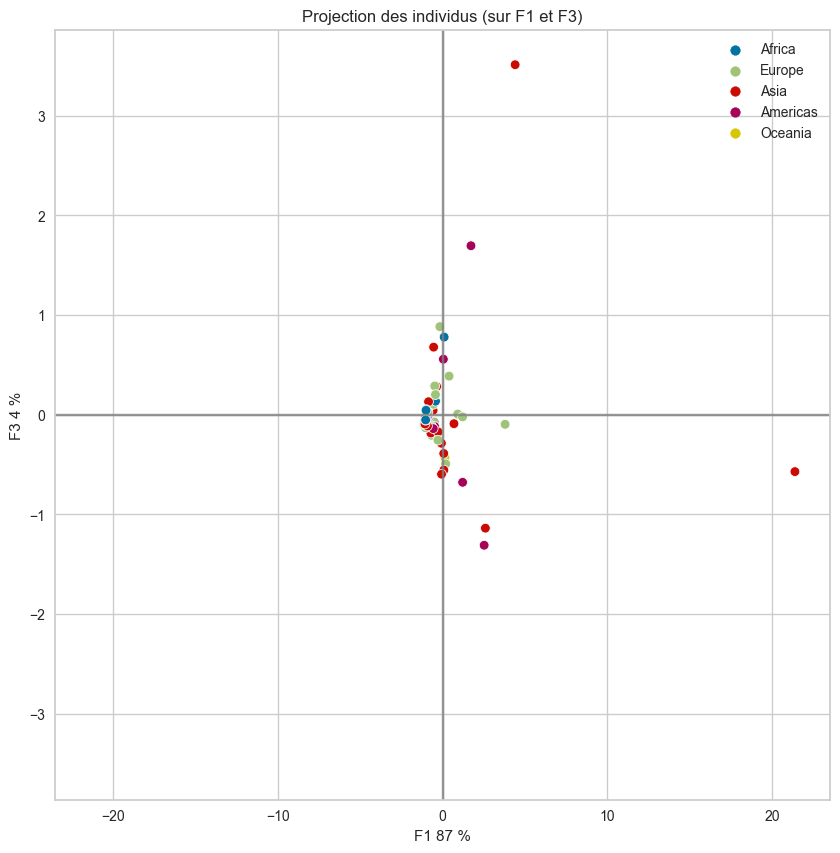

In [34]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,2),clusters=region)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


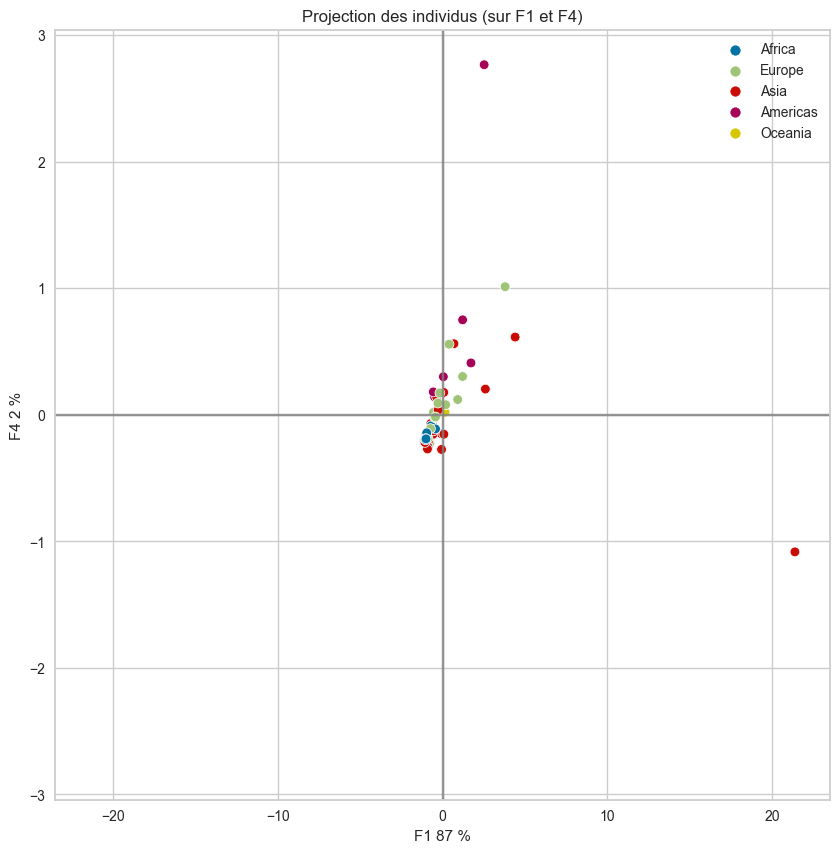

In [35]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,3),clusters=region)

Les variables sur F1 sont très proches les unes des autres. Il y a peu de variance sur cette dimension.

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


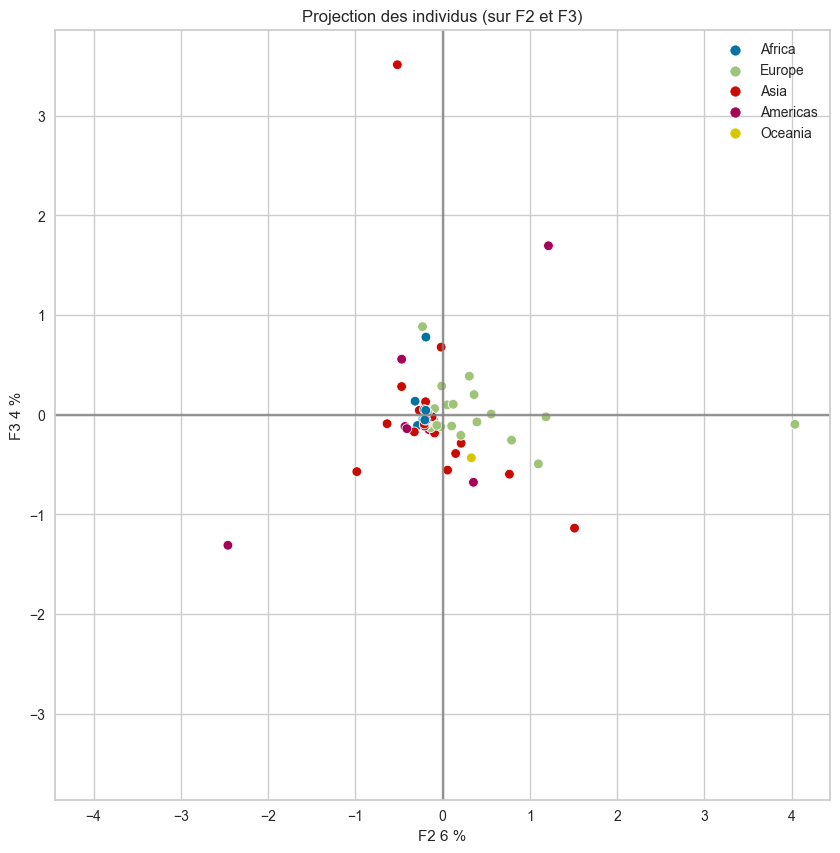

In [36]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,2),clusters=region)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


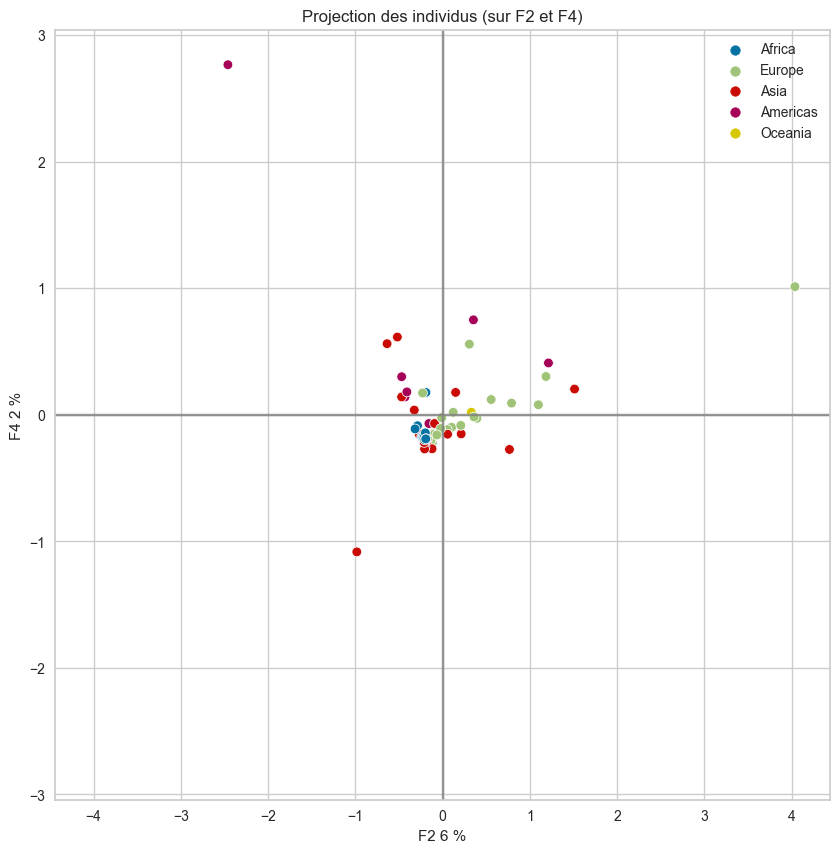

In [37]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,3),clusters=region)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


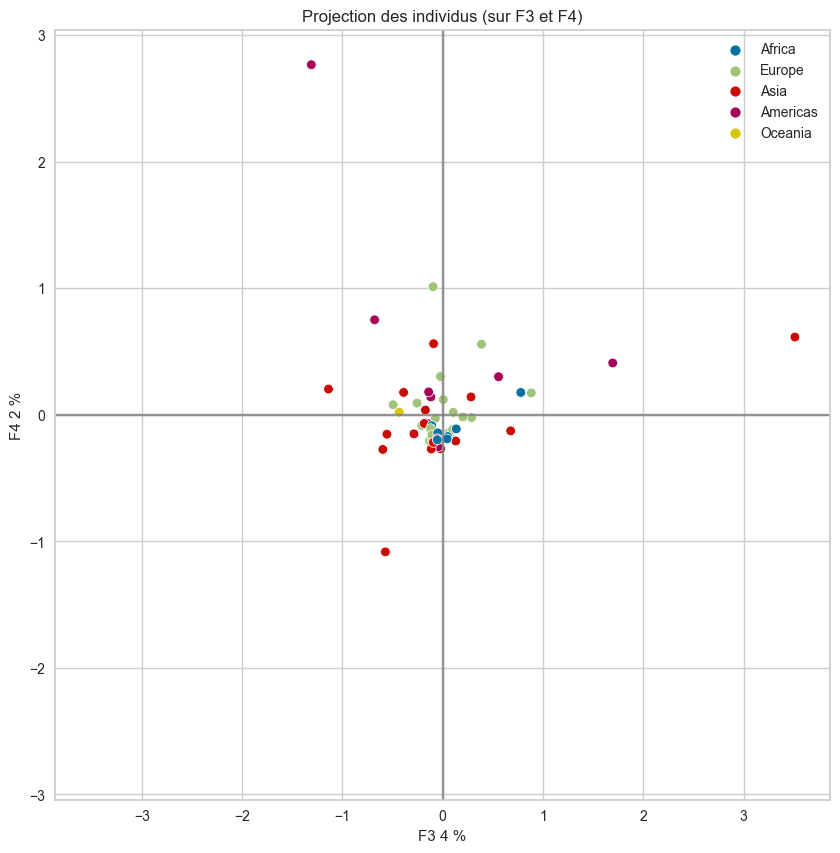

In [38]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(2,3),clusters=region)

Il y a bien plus de disparité sur les autres dimensions. Mais elles ne représentent qu'envion 20% de la variance.

## CAH

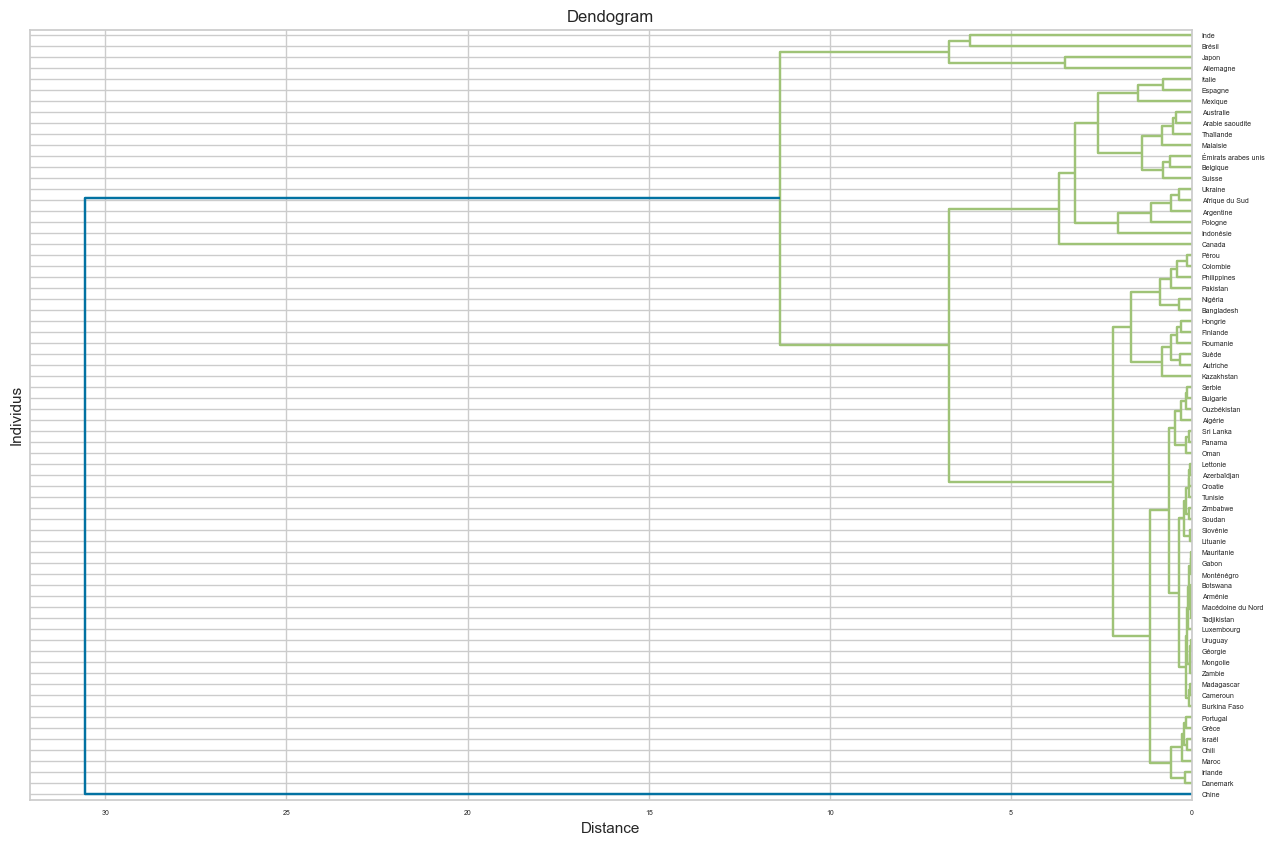

In [39]:
cah = CAH(df, columns)
cah.scale(StandardScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah.dendrogram(ax)

Nous remarquons ici que la chine occupe à elle seule un cluster. Cela peut s'expliquer par le fait que la Chine est un pays très peuplé et est, en 2019, le deuxième plus gros producteur de poulet au monde. Ce pays nécessiterait une analyse à lui seul. Nous allons relancer la CAH sans la Chine pour étudier les autres clusters.

In [40]:
df2 = df[~df.index.str.contains(r'Chine')]

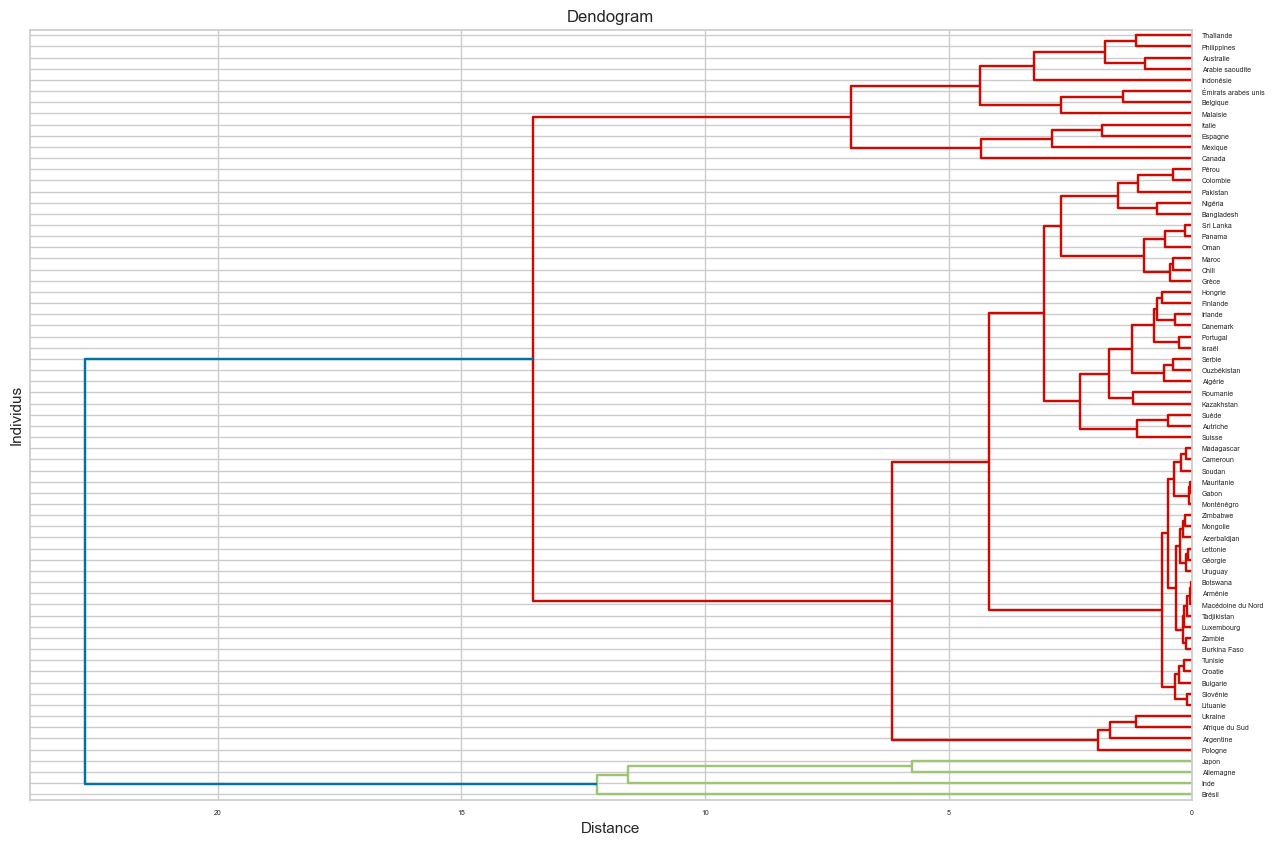

In [41]:
cah2 = CAH(df2, columns)
cah2.scale(StandardScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah2.dendrogram(ax)

Nous retrouvons ici un petit cluster composé du Japon de l'Allemagne, de l'Inde et du Brésil.
L'Inde est, au même titre que la Chine, un pays très peuplé. Le Brésil quant à lui est en 2019 le troisième plus gros producteur de poulet.
Il est plus difficile de trouver une explication pour le Japon est l'Allemagne : Etudions ces deux pays en les comparant aux autres.

In [42]:
df_jap_ger =  df.copy()
df_jap_ger['Japon/Allemagne'] = df.index.str.contains(r'Japon|Allemagne|Brésil')
df_jap_ger[df_jap_ger['Japon/Allemagne'] == True]

CO2 emissions (kt)  \
Zone                            
Allemagne            658693.5   
Brésil               434318.0   
Japon               1073645.3   

           Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                
Allemagne                                         15029605.0        
Brésil                                            10704669.0        
Japon                                             23276482.0        

           Merchandise exports (current US$)  \
Zone                                           
Allemagne                      1489412000000   
Brésil                          221127000000   
Japon                           705564000000   

           Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                        
Allemagne                      1233978000000                      33423.0   
Brésil                          193162000000                       2977.5   
Japon                           720957000000                       2977.5   

           PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                      
Allemagne     3.888327e+06                                       1544.0   
Brésil        1.886015e+06                                      14094.0   
Japon         5.148782e+06                                       2298.0   

           Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                     
Allemagne           63787.507                                  12920.0   
Brésil             184407.548                                  47668.0   
Japon              116322.813                                  13040.0   

           Japon/Allemagne  
Zone                        
Allemagne             True  
Brésil                True  
Japon                 True

Text(0.5, 0.98, 'Boxplot by Japon/Allemagne/ for each features')

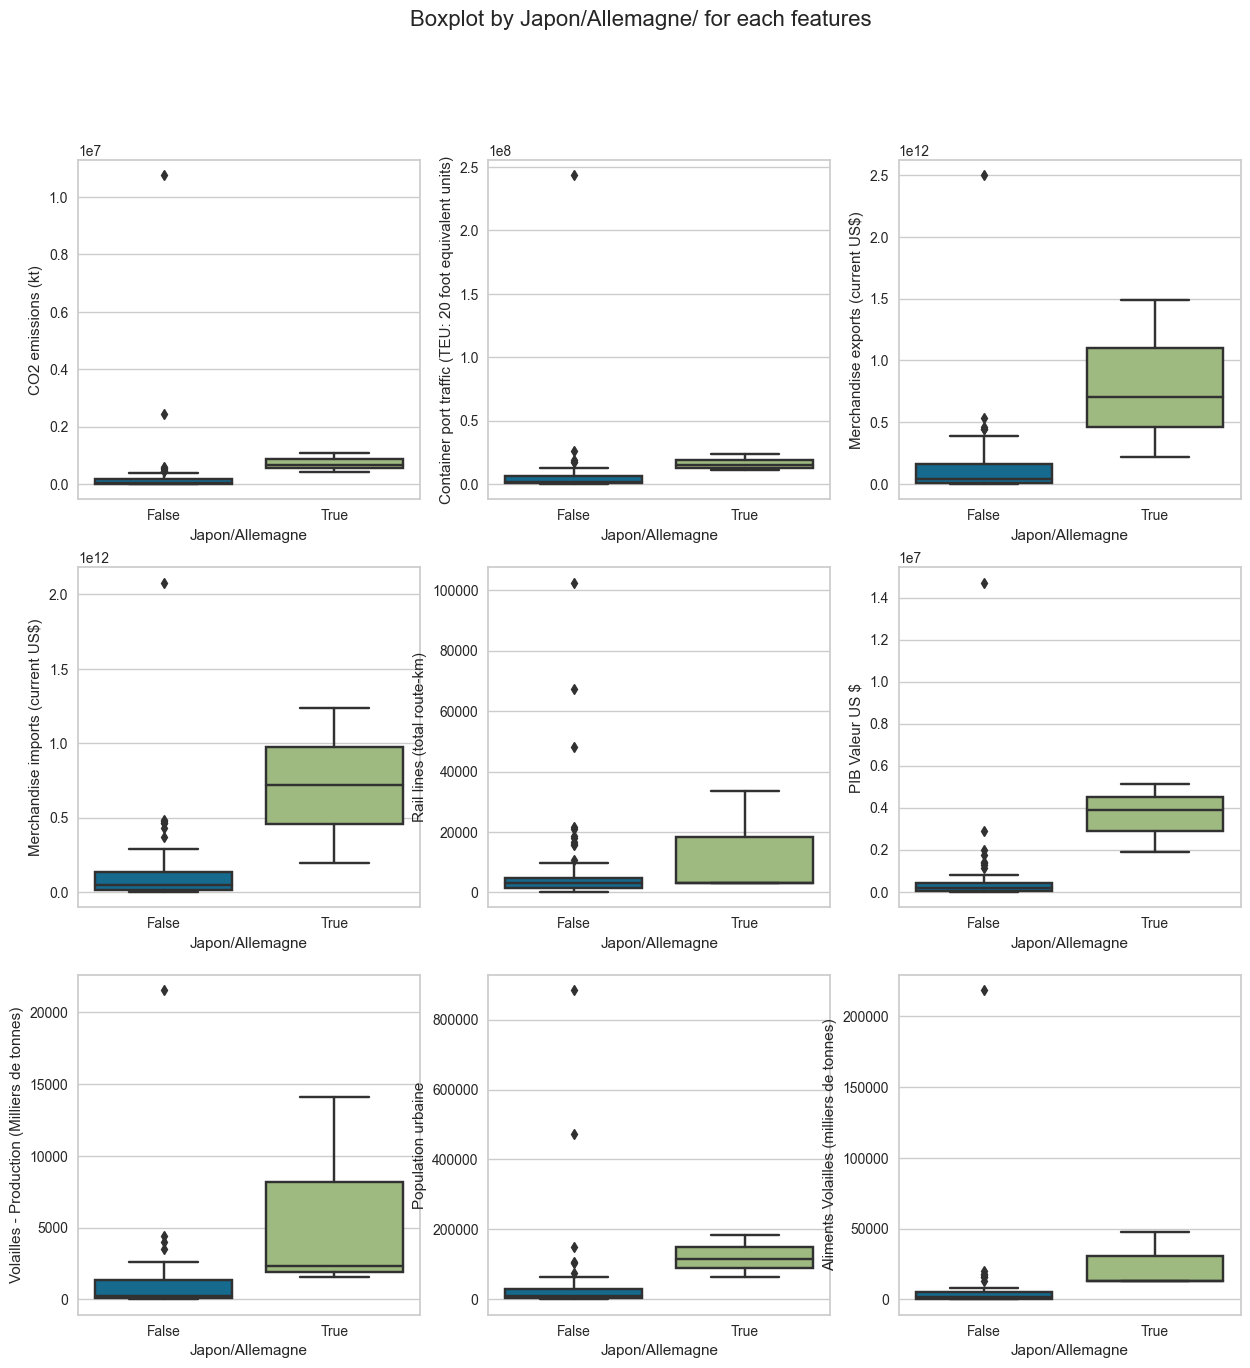

In [43]:
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="Japon/Allemagne", y="CO2 emissions (kt)", data=df_jap_ger, ax=ax[0,0])
sns.boxplot(x="Japon/Allemagne", y="Container port traffic (TEU: 20 foot equivalent units)", data=df_jap_ger, ax=ax[0,1])
sns.boxplot(x="Japon/Allemagne", y="Merchandise exports (current US$)", data=df_jap_ger, ax=ax[0,2])
sns.boxplot(x="Japon/Allemagne", y="Merchandise imports (current US$)", data=df_jap_ger, ax=ax[1,0])
sns.boxplot(x="Japon/Allemagne", y="Rail lines (total route-km)", data=df_jap_ger, ax=ax[1,1])
sns.boxplot(x="Japon/Allemagne", y="PIB Valeur US $", data=df_jap_ger, ax=ax[1,2])
sns.boxplot(x="Japon/Allemagne", y="Volailles - Production (Milliers de tonnes)", data=df_jap_ger, ax=ax[2,0])
sns.boxplot(x="Japon/Allemagne", y="Population urbaine", data=df_jap_ger, ax=ax[2,1])
sns.boxplot(x="Japon/Allemagne", y="Aliments Volailles (milliers de tonnes)", data=df_jap_ger, ax=ax[2,2])
fig.suptitle('Boxplot by Japon/Allemagne/ for each features', fontsize=16)

Nous pouvons remarquer que le Japon et L'Allemagne sont dans bien des cas dans la zone des outliers. Nous allons donc les retirer de l'analyse. Ils nécessiteraient une analyse à eux seul.

## Kmeans

Pour le K-means, nous allons simplement étudier le résultat sans le retrait du Japon, de l'Allemagne, de la Chine, de l'Inde et du Brésil. Nous relancerons une analyse ultérieurement (ACP/CAH/Kmeans) sans ces pays.

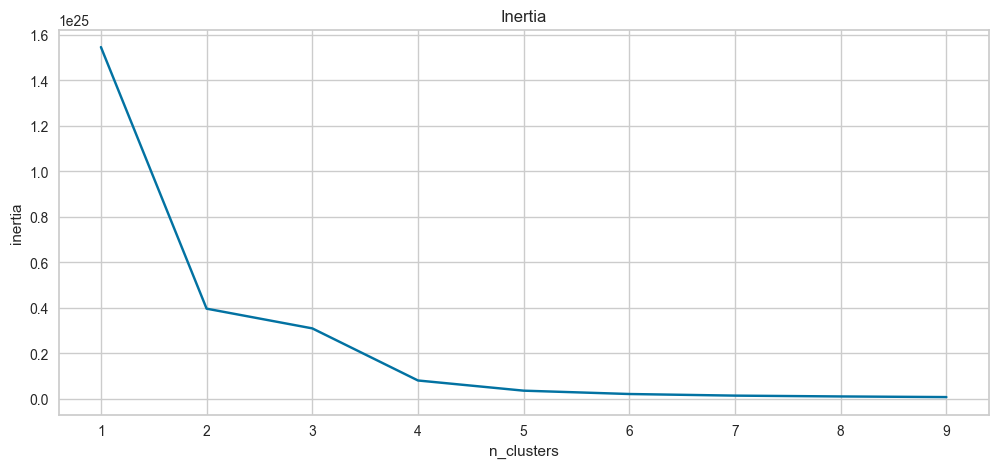

In [44]:
km = kmeans(df, columns)
fig, ax = plt.subplots(figsize=(12, 5))
km.plot_inertia(ax)


For n_clusters = 2, silhouette score is 0.894)
For n_clusters = 3, silhouette score is 0.844)
For n_clusters = 4, silhouette score is 0.715)
For n_clusters = 5, silhouette score is 0.688)


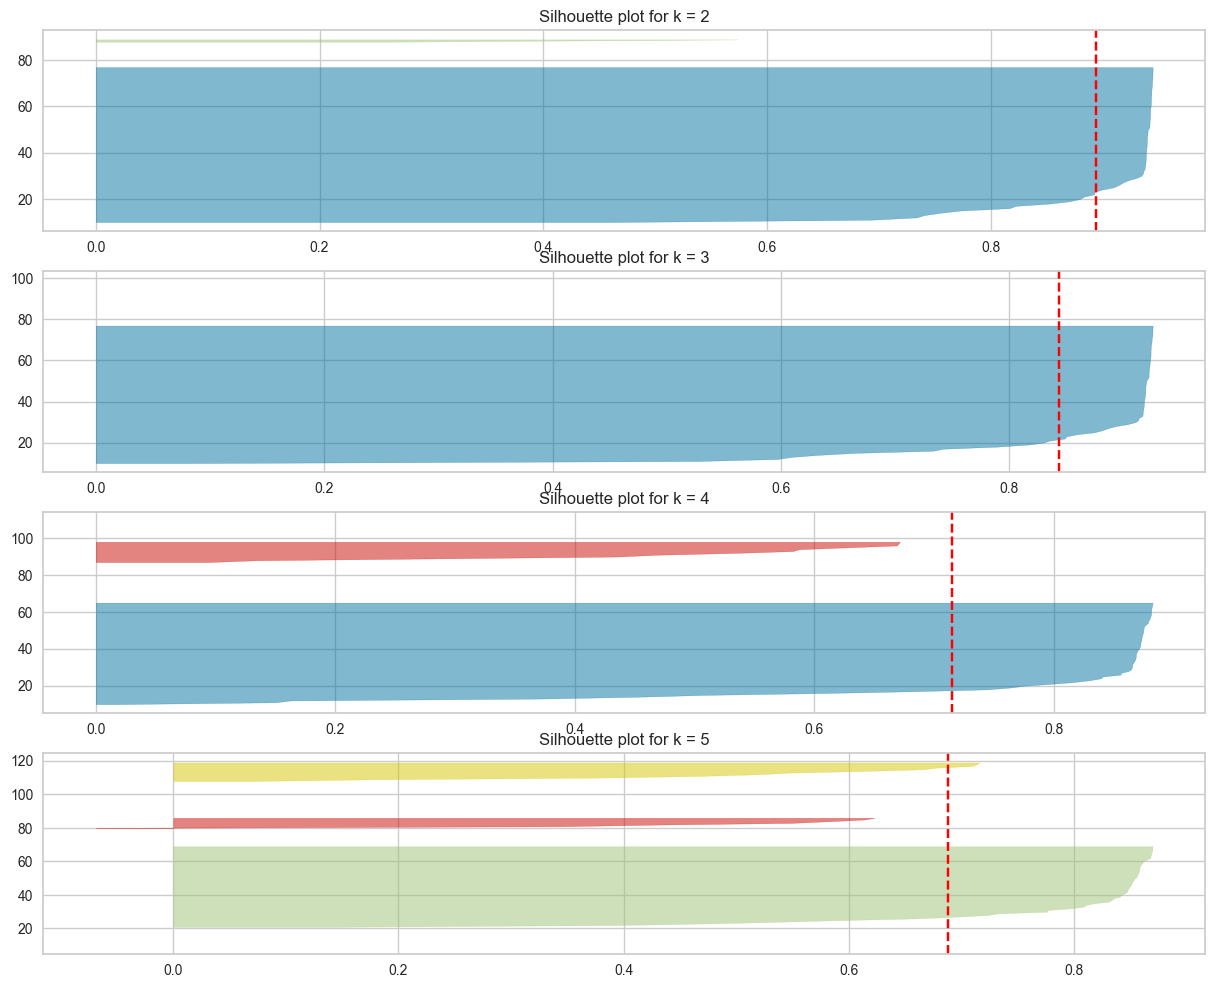

In [45]:
fig, ax = plt.subplots(4,1,figsize=(15, 12))
km.plot_silhouette(ax,[2,3,4,5])

Si l'on s'intéresse graphique de silhouette, on remarque que pour K=2 les clusters sont assez mal définit : Nous avons un énorme cluster et un autre qui est composé de très peu de pays. Nous pouvons déjà penser à des pays comme la Chine, le Brésil ou l'Inde.

In [46]:
km.kmean_choose(2)
km.clusters

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

In [47]:
df['cluster']=km.clusters
columns.append('cluster')

### CLusters

In [48]:
df.columns

Index(['CO2 emissions (kt)',
       'Container port traffic (TEU: 20 foot equivalent units)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)', 'Rail lines (total route-km)',
       'PIB Valeur US $', 'Volailles - Production (Milliers de tonnes)',
       'Population urbaine', 'Aliments Volailles (milliers de tonnes)',
       'cluster'],
      dtype='object')

In [49]:
km_df = df[columns]

Text(0.5, 0.98, 'Boxplot by clusters for each features')

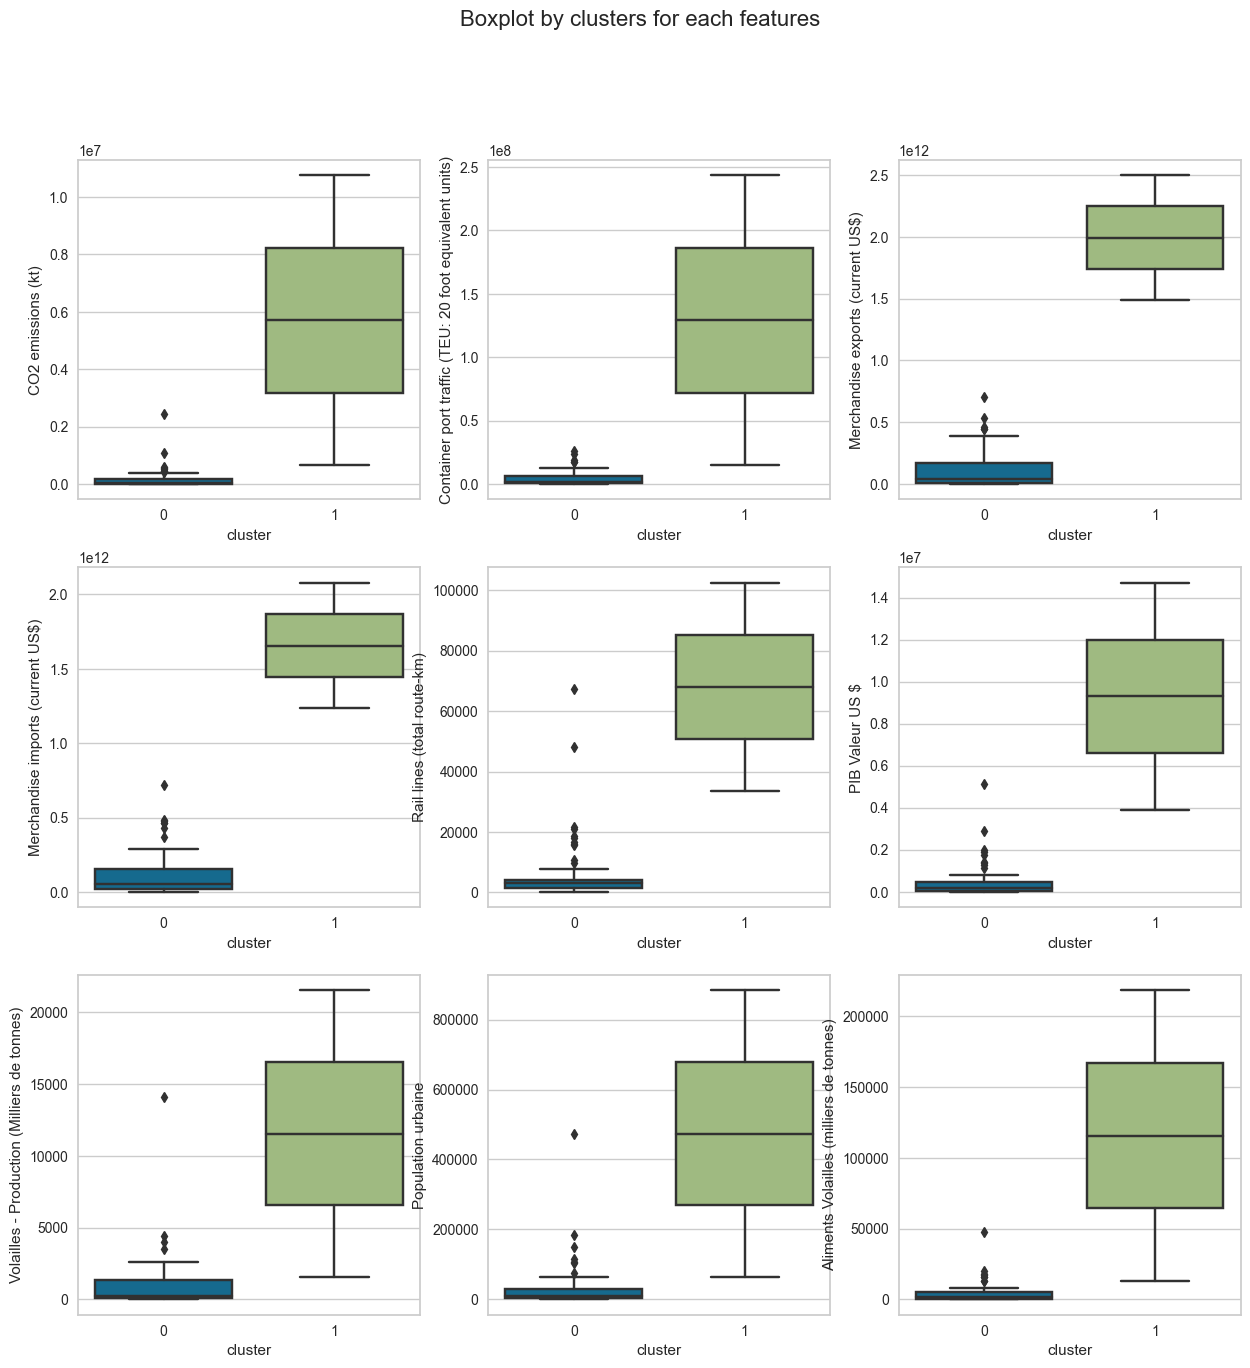

In [50]:
# box plot by clusters for each feature
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="cluster", y="CO2 emissions (kt)", data=km_df, ax=ax[0,0])
sns.boxplot(x="cluster", y="Container port traffic (TEU: 20 foot equivalent units)", data=km_df, ax=ax[0,1])
sns.boxplot(x="cluster", y="Merchandise exports (current US$)", data=km_df, ax=ax[0,2])
sns.boxplot(x="cluster", y="Merchandise imports (current US$)", data=km_df, ax=ax[1,0])
sns.boxplot(x="cluster", y="Rail lines (total route-km)", data=km_df, ax=ax[1,1])
sns.boxplot(x="cluster", y="PIB Valeur US $", data=km_df, ax=ax[1,2])
sns.boxplot(x="cluster", y="Volailles - Production (Milliers de tonnes)", data=km_df, ax=ax[2,0])
sns.boxplot(x="cluster", y="Population urbaine", data=km_df, ax=ax[2,1])
sns.boxplot(x="cluster", y="Aliments Volailles (milliers de tonnes)", data=km_df, ax=ax[2,2])
fig.suptitle('Boxplot by clusters for each features', fontsize=16)

In [51]:
cluster0 = km_df[km_df['cluster']==0]
cluster0

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                 446626.0   
Algérie                        170582.4   
Arabie saoudite                526770.3   
Argentine                      168162.0   
Arménie                          6195.6   
...                                 ...   
Ukraine                        174599.9   
Uruguay                          6806.7   
Zambie                           7615.7   
Zimbabwe                        10185.3   
Émirats arabes unis            185645.7   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               4529034.0        
Algérie                                                      1793990.0        
Arabie saoudite                                              8905621.0        
Argentine                                                    1833964.0        
Arménie                                                      1229081.0        
...                                                                ...        
Ukraine                                                      1007273.0        
Uruguay                                                       749562.0        
Zambie                                                       1229081.0        
Zimbabwe                                                     1229081.0        
Émirats arabes unis                                         18802000.0        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                             90016000000   
Algérie                                    35312000000   
Arabie saoudite                           261603000000   
Argentine                                  65116000000   
Arménie                                     2640000000   
...                                                ...   
Ukraine                                    50054000000   
Uruguay                                     7680000000   
Zambie                                      7039000000   
Zimbabwe                                    4269000000   
Émirats arabes unis                       389428000000   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                            107539000000   
Algérie                                    44632000000   
Arabie saoudite                           153163000000   
Argentine                                  49124000000   
Arménie                                     5514000000   
...                                                ...   
Ukraine                                    60800000000   
Uruguay                                     8246000000   
Zambie                                      7173000000   
Zimbabwe                                    4817000000   
Émirats arabes unis                       288447000000   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          20953.00    351430.991183   
Algérie                                  4020.25    171158.234285   
Arabie saoudite                          2977.50    792966.838190   
Argentine                               17866.00    445445.254556   
Arménie                                   698.40     13619.290546   
...                                          ...              ...   
Ukraine                                 21625.90    153929.552493   
Uruguay                                  1498.00     61231.193299   
Zambie                                   1248.00     23309.720448   
Zimbabwe                                 3120.00     21935.075306   
Émirats arabes unis                       261.00    417215.559513   

                     Vola

In [52]:
cluster1 = km_df[km_df['cluster']==1]
cluster1

CO2 emissions (kt)  \
Zone                            
Allemagne            658693.5   
Chine              10762824.0   

           Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                
Allemagne                                         15029605.0        
Chine                                            243560000.0        

           Merchandise exports (current US$)  \
Zone                                           
Allemagne                      1489412000000   
Chine                          2499457000000   

           Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                        
Allemagne                      1233978000000                      33423.0   
Chine                          2078386000000                     102462.0   

           PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                      
Allemagne     3.888327e+06                                       1544.0   
Chine         1.470083e+07                                      21518.0   

           Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                     
Allemagne           63787.507                                  12920.0   
Chine              883204.937                                 218290.0   

           cluster  
Zone                
Allemagne        1  
Chine            1

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


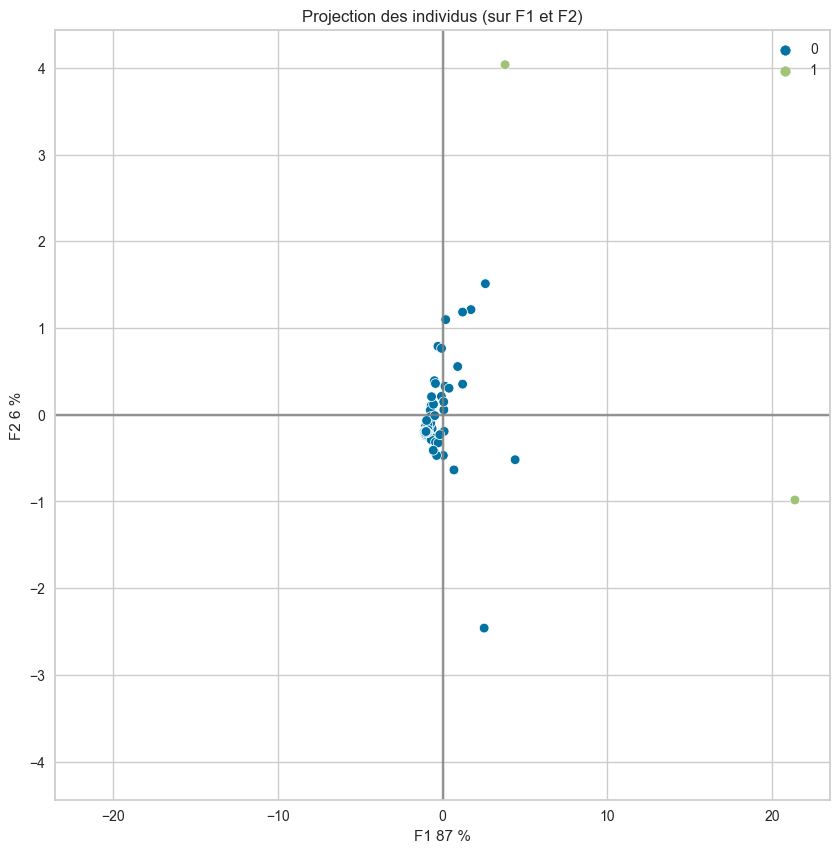

In [53]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


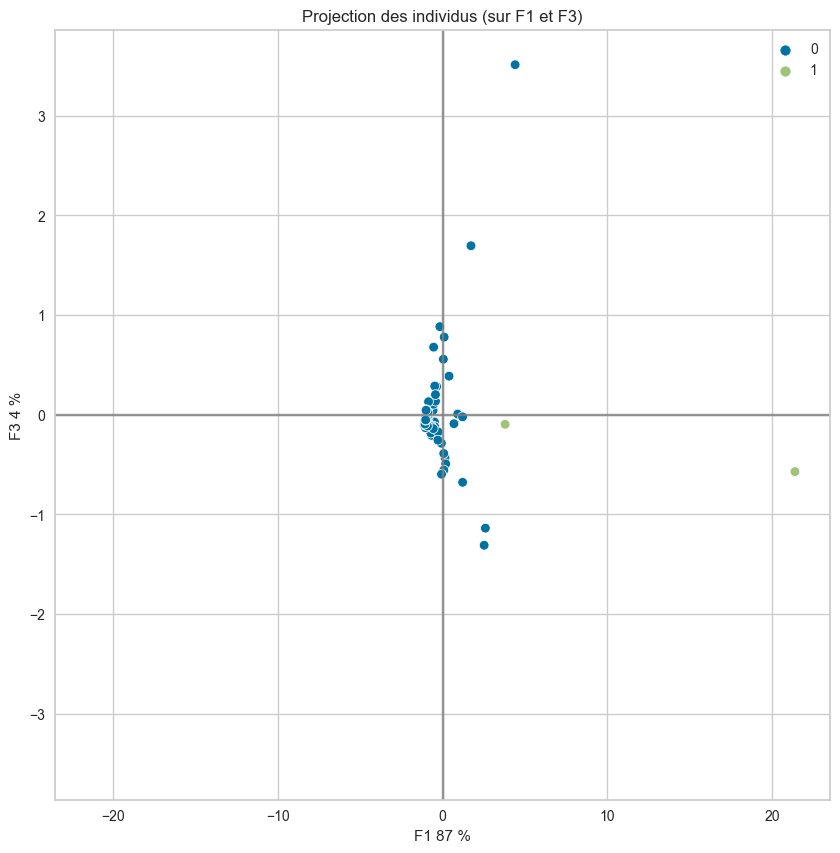

In [54]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,2),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


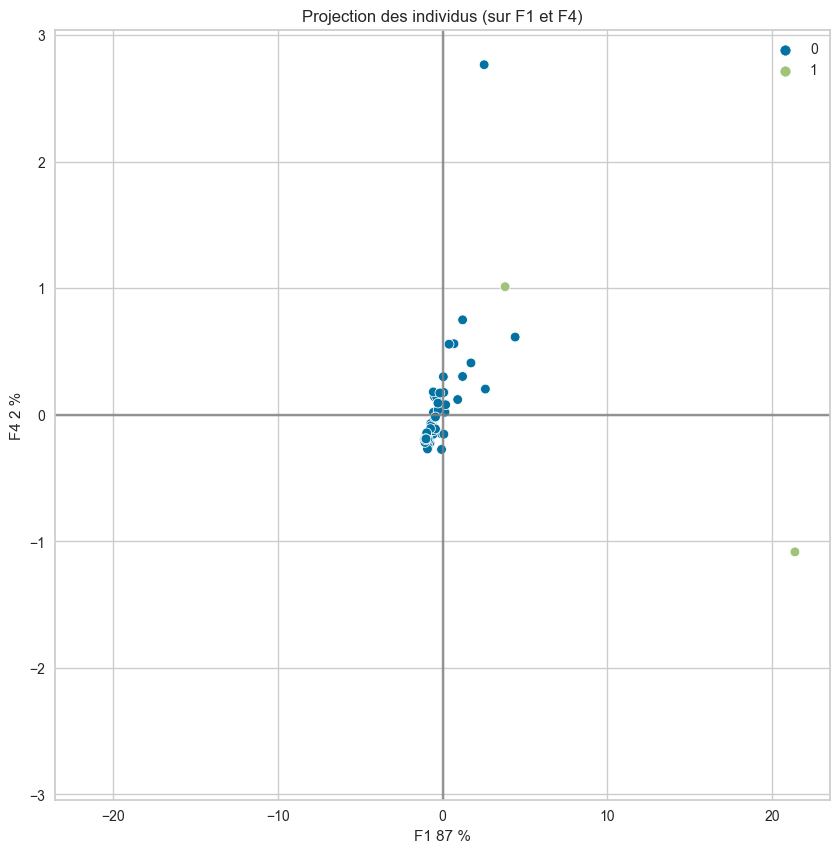

In [55]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,3),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


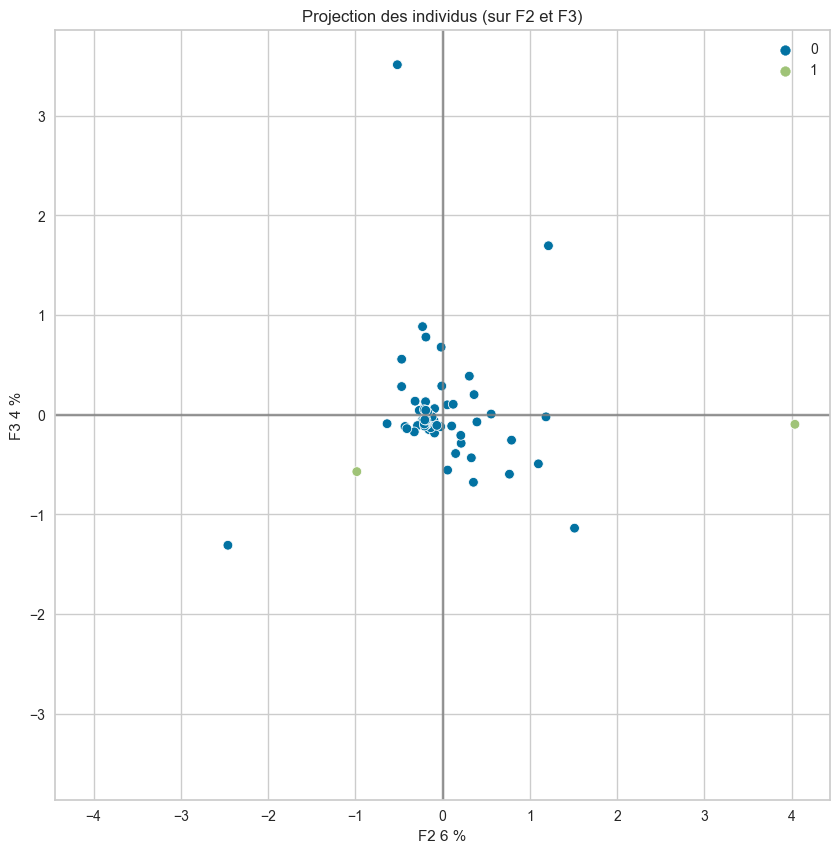

In [56]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,2),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


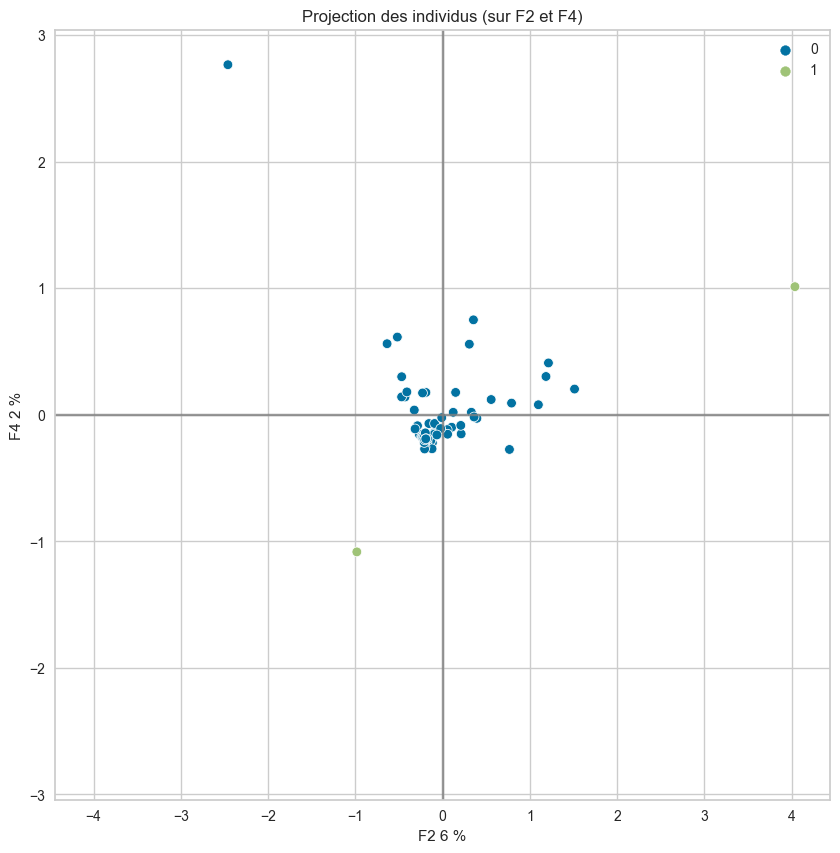

In [57]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,3),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


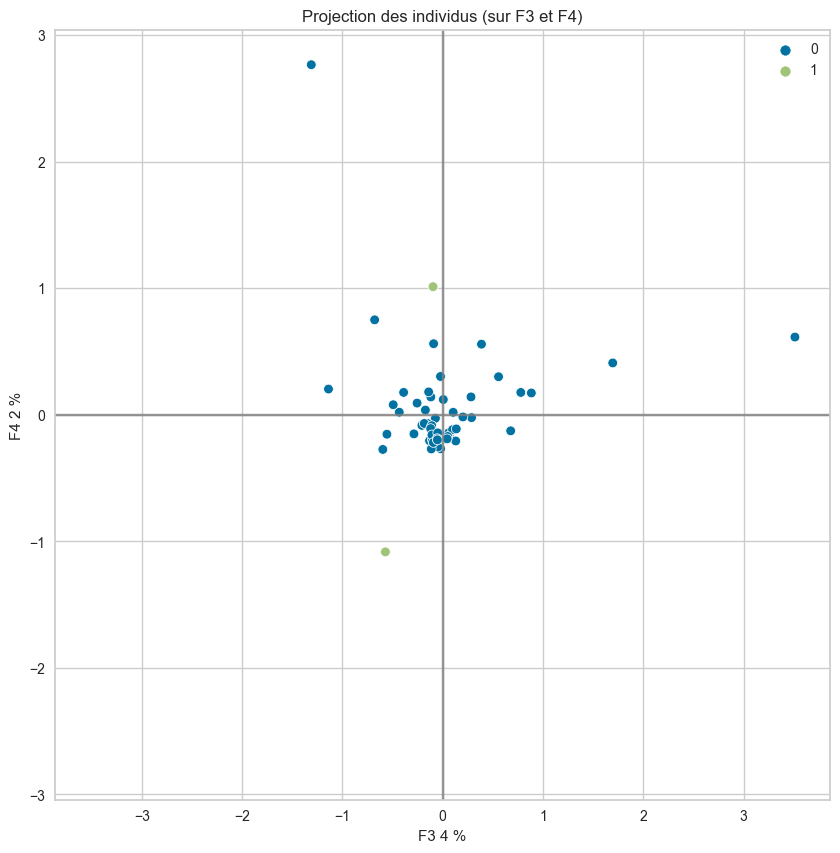

In [58]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(2,3),clusters=km.clusters)

# Analyse 2 
Nous allons refaire l'analyse complete avec les pays que nous avons écarté précédemment.

In [59]:
df = df_og.copy()

In [60]:
df=df[~df.index.str.contains(r'Chine|Inde|Brésil|Japon|Allemagne')]
region = df['region'].tolist()
df = df.drop(columns=['region'])
columns = df.columns.tolist()
df.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Arabie saoudite            526770.3   
Argentine                  168162.0   
Arménie                      6195.6   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        
Arménie                                                  1229081.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   
Arménie                                 2640000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   
Arménie                                 5514000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00    351430.991183   
Algérie                              4020.25    171158.234285   
Arabie saoudite                      2977.50    792966.838190   
Argentine                           17866.00    445445.254556   
Arménie                               698.40     13619.290546   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   
Arménie                                                 12.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  
Zone                                                                          
Afrique du Sud            38820.239                                   5721.0  
Algérie                   31236.431                                   4152.0  
Arabie saoudite           28700.362                                   2511.0  
Argentine                 41489.566                                  16050.0  
Arménie                    1856.542                                    134.0

## PCA

Explained variance ratio:  [62.72 12.72 11.06  4.75  4.05  2.07]
Cumulative explained variance ratio:  [63. 75. 86. 91. 95. 97.]


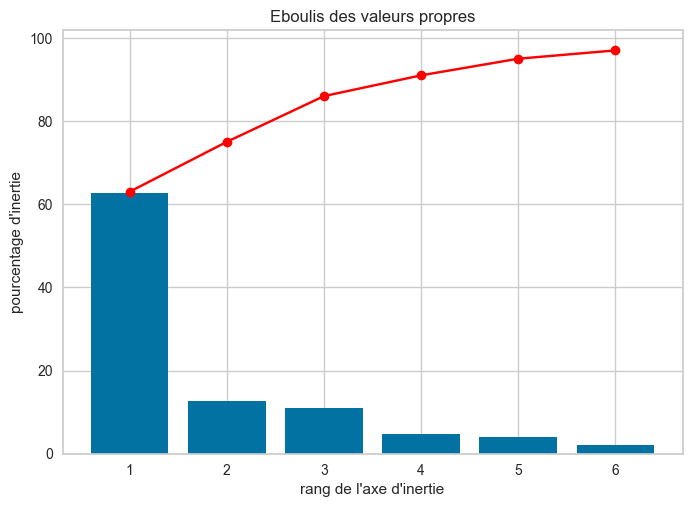

In [61]:
pca2 = c_PCA(df, columns,6)
pca2.scale(StandardScaler())
pca2.pca_evr()

Nous pouvons déjà remarquer un impact sur notre PCA. En effet, nous maintenant 60% de la variance expliquée sur l'Axe 1. Avec 4 dimensions, nous pourrons expliquer environ 90% de la variance.

### Cercles Correlations

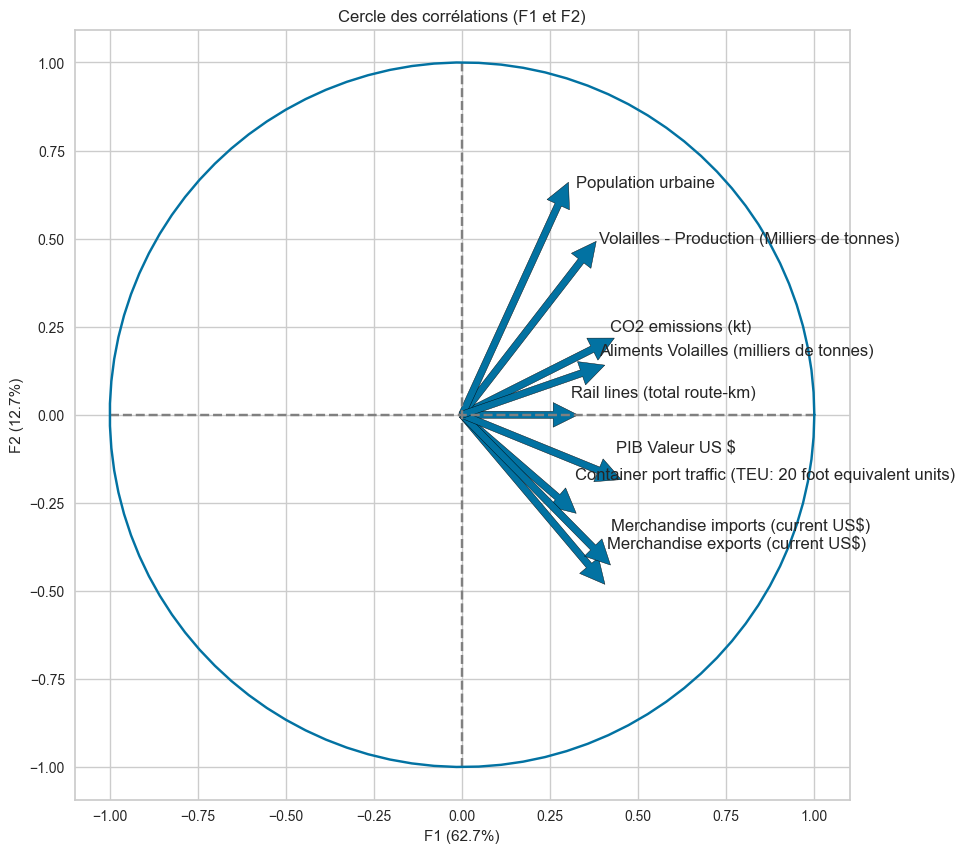

In [62]:
corr1, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,1))

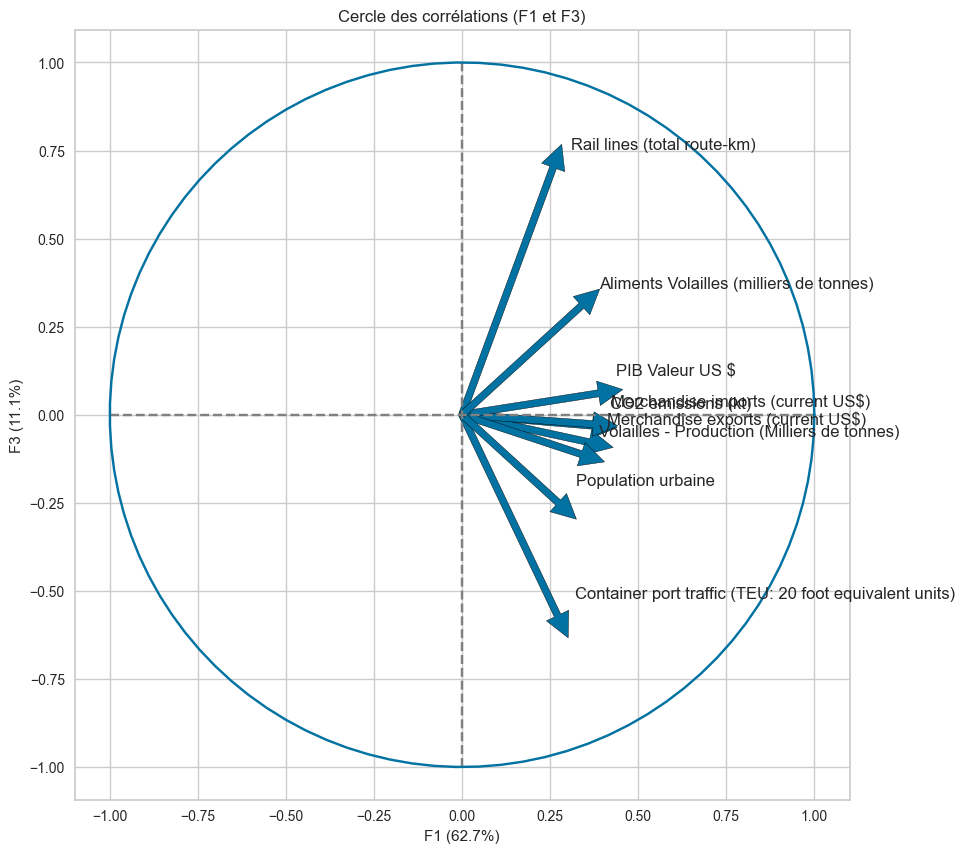

In [63]:
corr2, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,2))

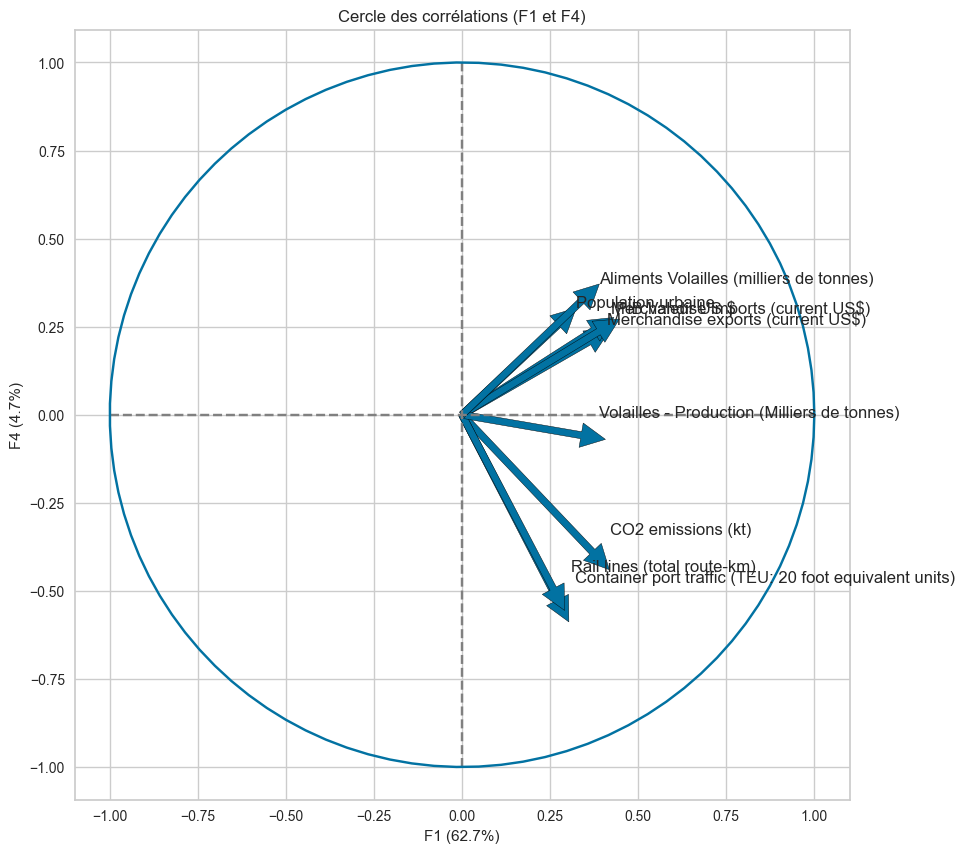

In [64]:
corr3, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,3))

La conclusion sur F1 est similaire à l'analyse précédente : Les variables ne se départagent pas sur F1, ce qui nous empêche de bien pouvoir l'intérpréter correctement.

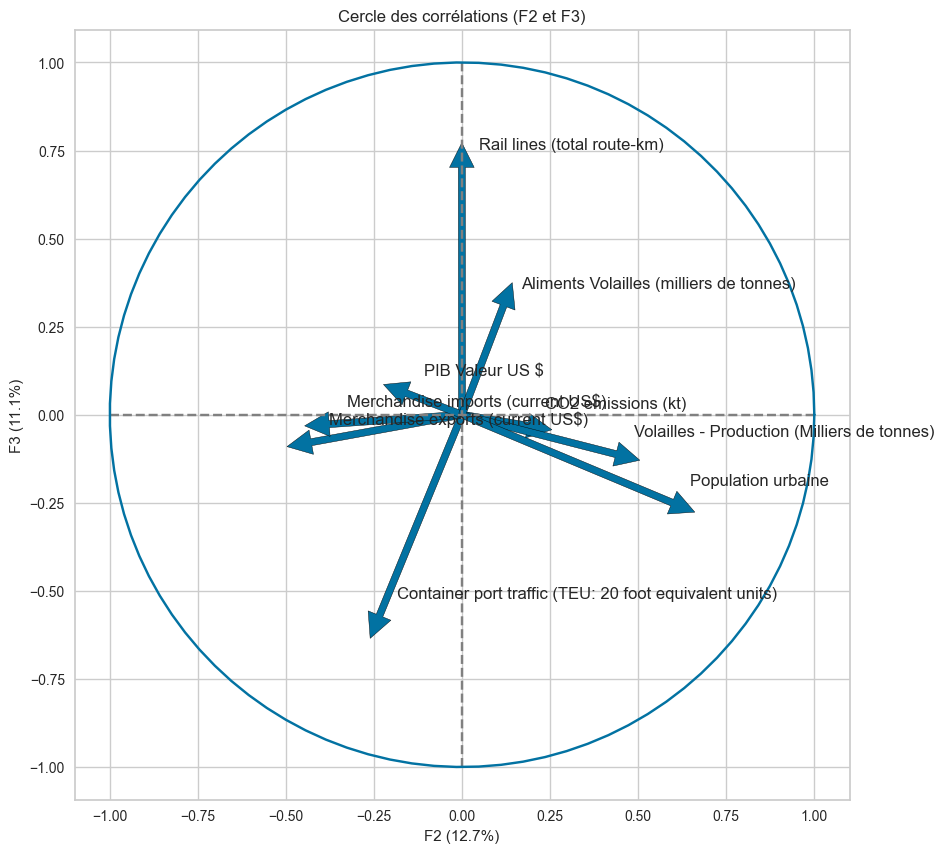

In [65]:
corr4, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (1,2))

F2 montre ici une corrélation modérée de la population urbain sur cette dimension. Nous retrouvons sur F3 notre corrélation positive sur le réseau féroviaire et notre corrélation négative sur les émissions de CO2. 

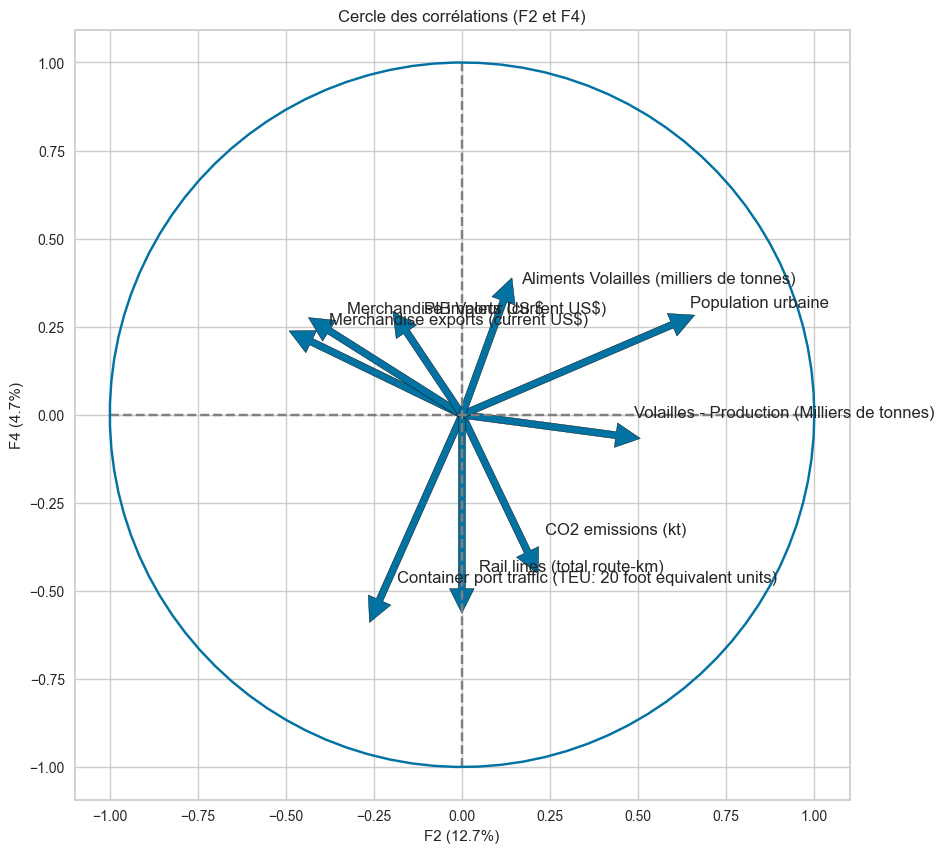

In [66]:
corr5, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (1,3))

F4 possède elle un corrélation modérée négative. 

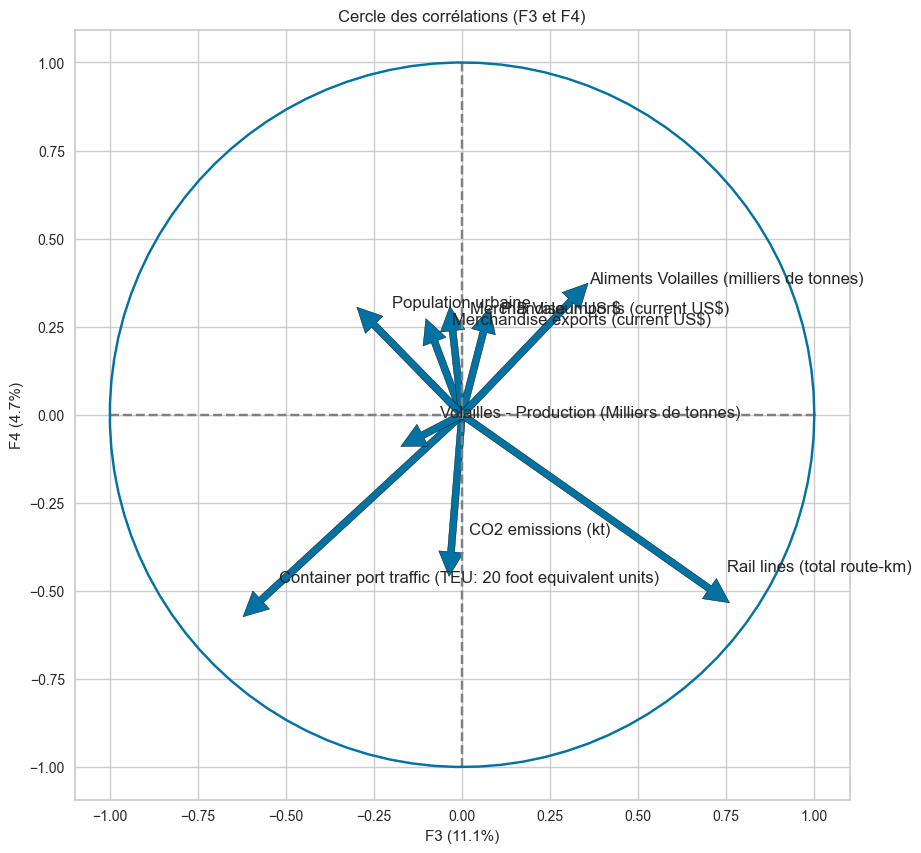

In [67]:
corr6, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (2,3))

### Projection des individus

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


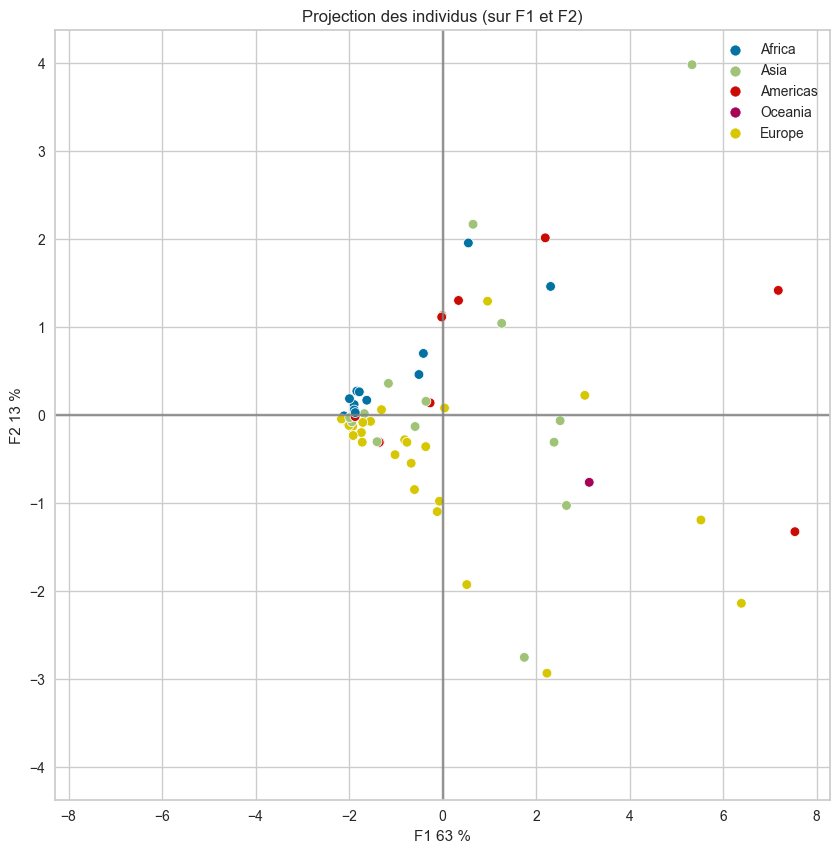

In [68]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,1), clusters=region)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


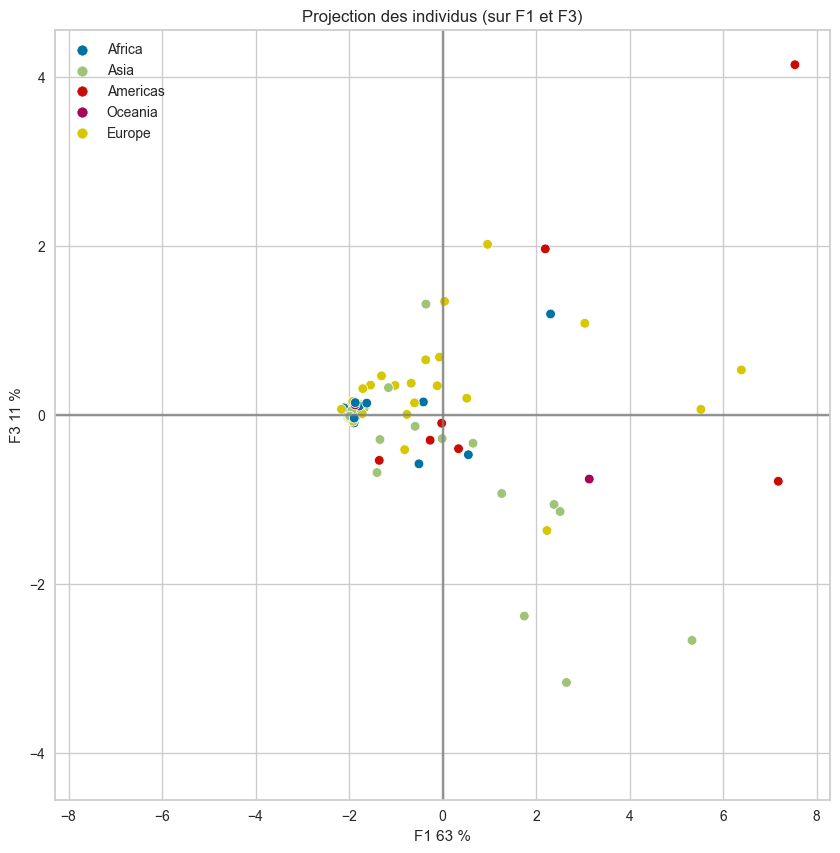

In [69]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,2),clusters=region)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


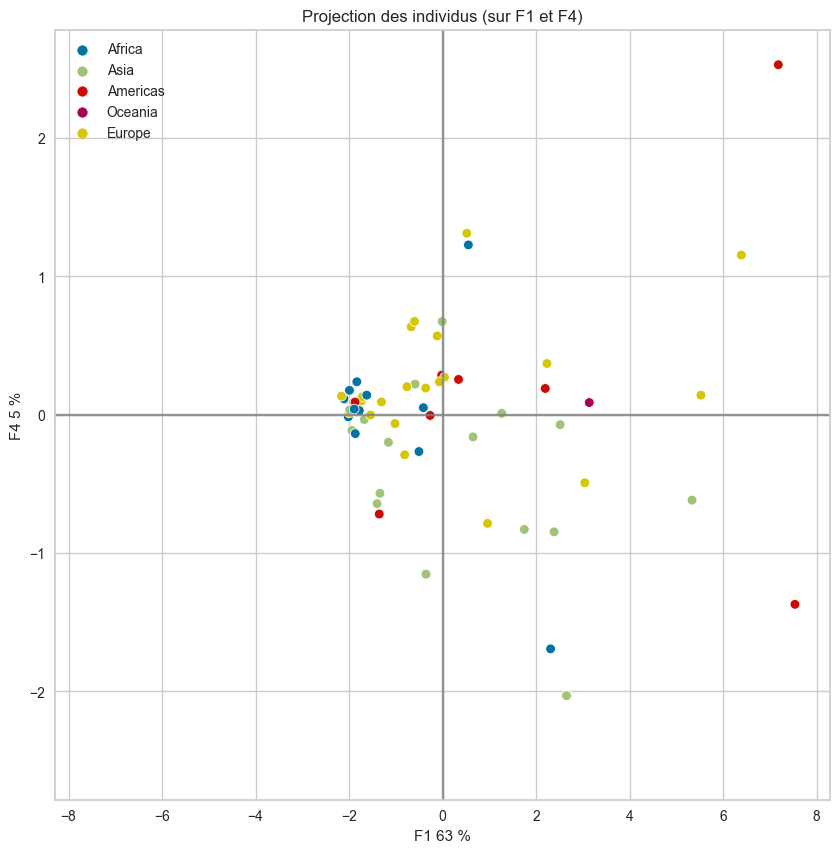

In [70]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,3),clusters=region)

Nous remarquons ici que les individus ne sont plus "tassés" comme lors de notre analyse précédente. Nous avons une meilleure répartition des individus sur les dimensions.

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


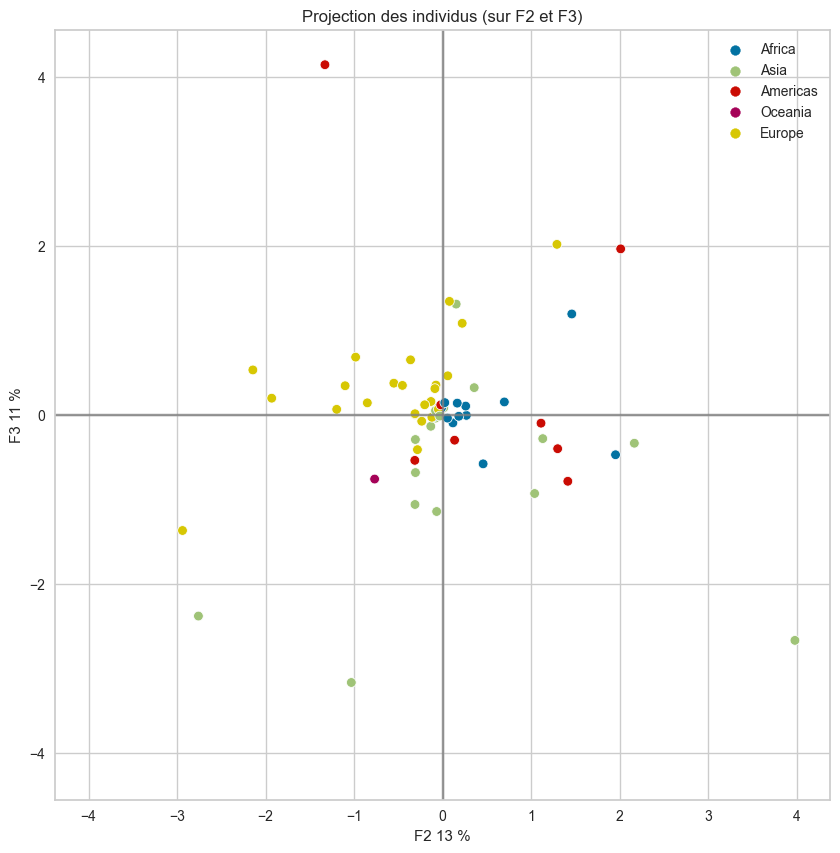

In [71]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,2),clusters=region)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


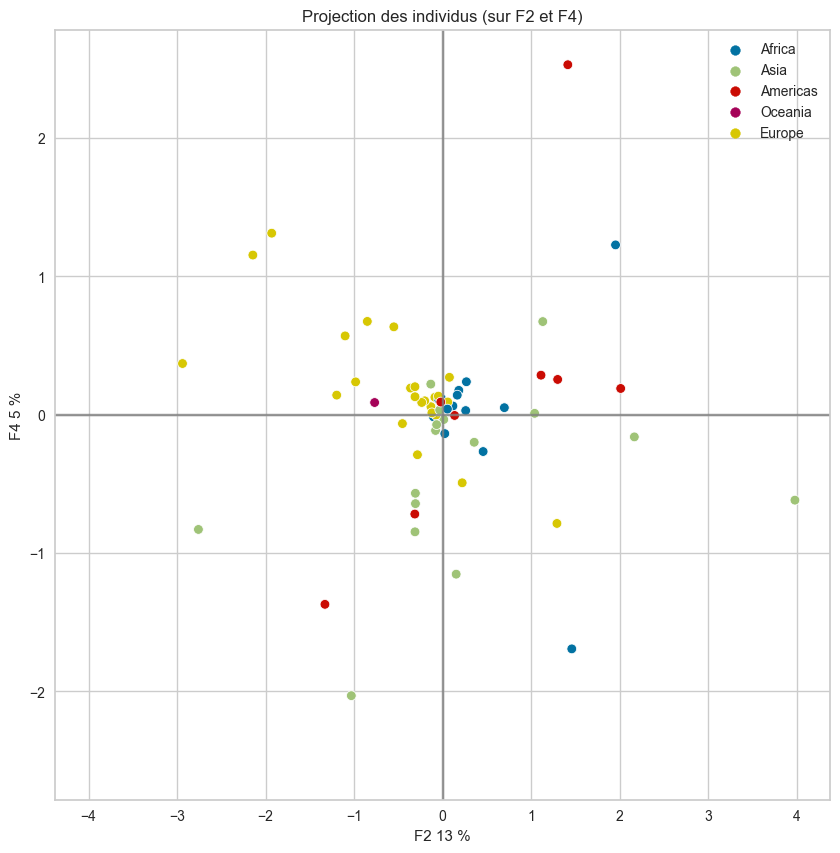

In [72]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,3),clusters=region)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


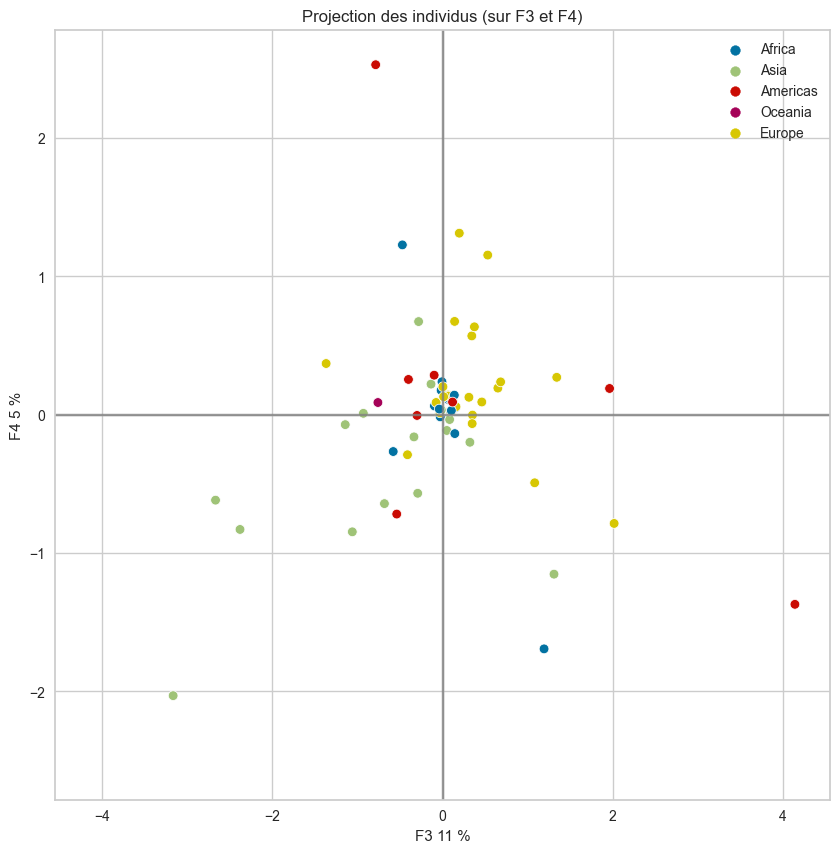

In [73]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(2,3),clusters=region)

## CAH

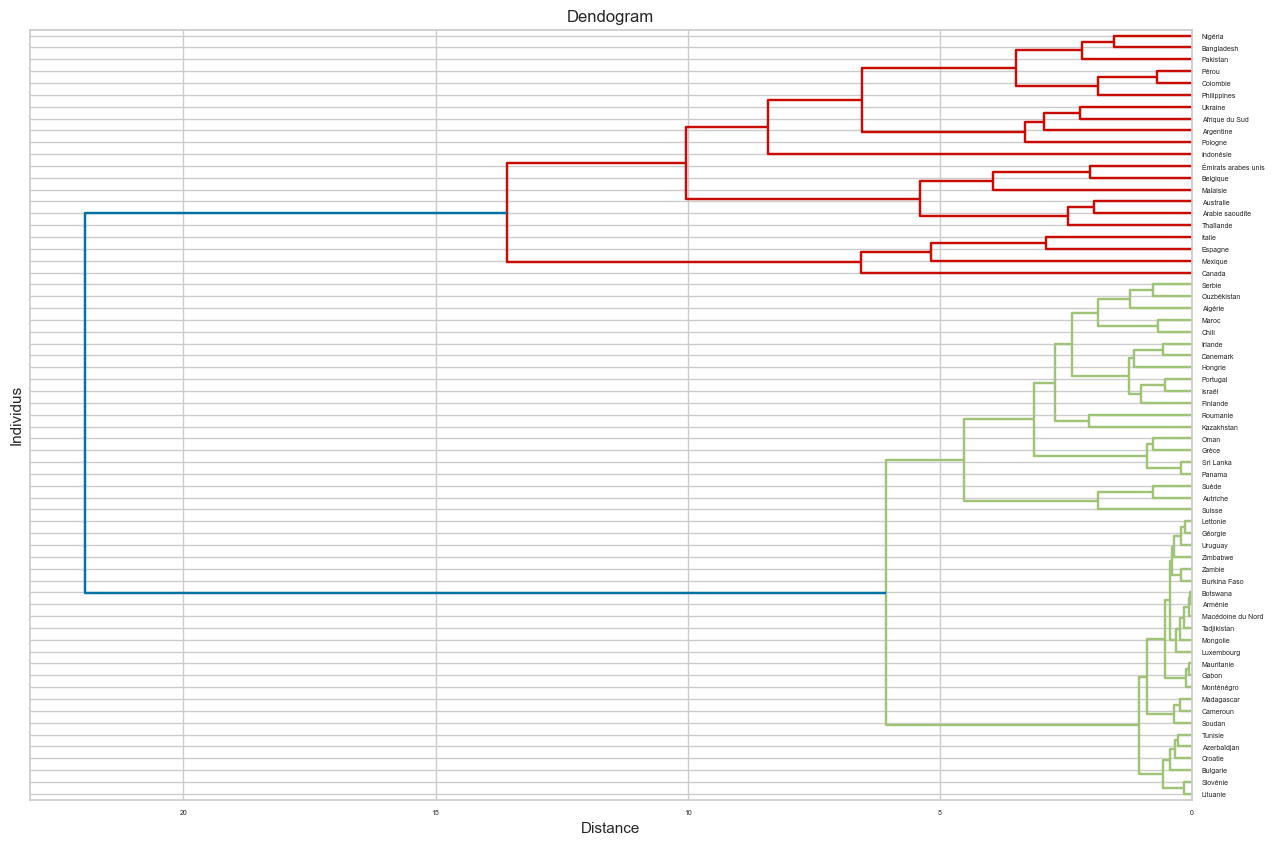

In [74]:
cah3 = CAH(df, columns)
cah3.scale(StandardScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah3.dendrogram(ax)

Après l'exclusion des pays précédents, nous pouvons voire ici deux cluster relativement homogènes. Nous pourrions même considérer trois clusters (l'un des clusters seraient l'Italie, l'Espagne, le Mexique et le Canada).

## Kmeans

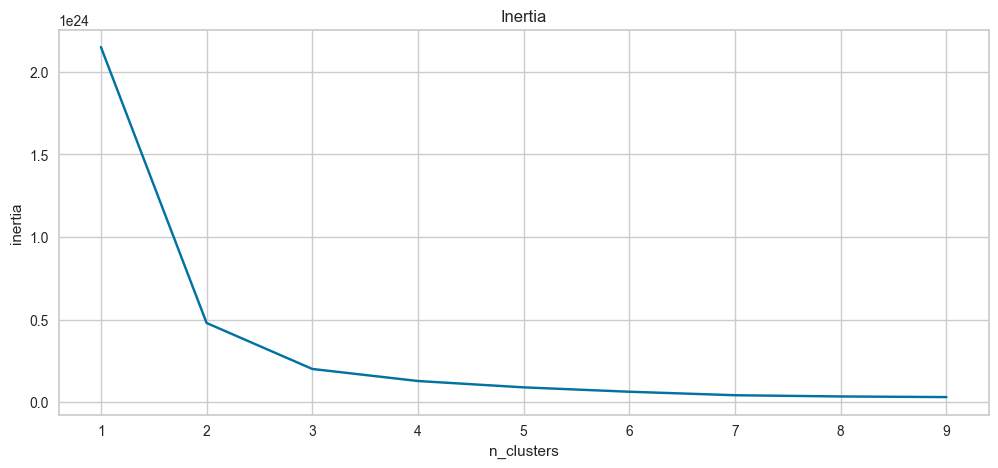

In [75]:
km = kmeans(df, columns)
fig, ax = plt.subplots(figsize=(12, 5))
km.plot_inertia(ax)


For n_clusters = 2, silhouette score is 0.756)
For n_clusters = 3, silhouette score is 0.712)
For n_clusters = 4, silhouette score is 0.554)
For n_clusters = 5, silhouette score is 0.549)


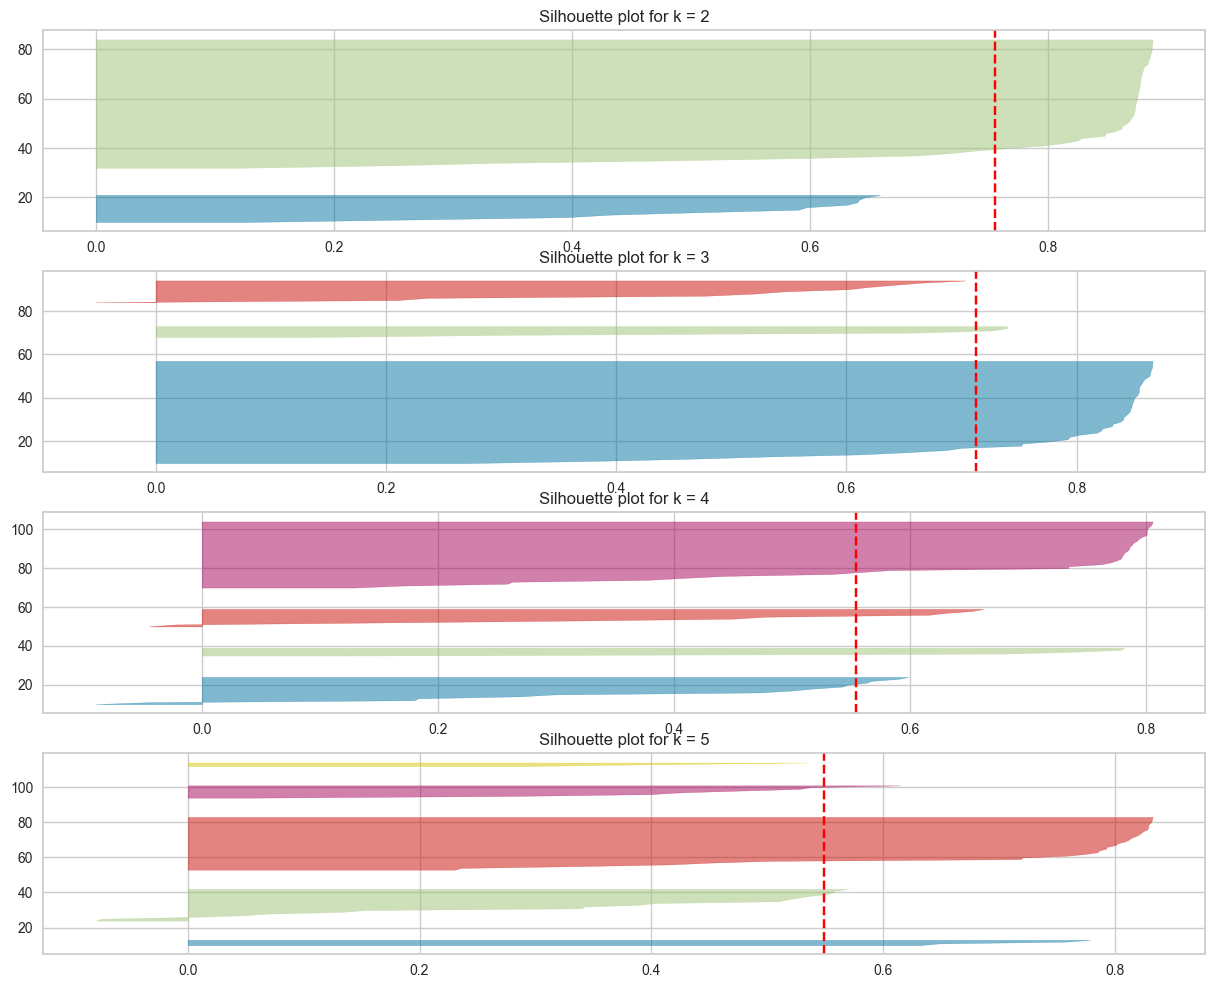

In [76]:
fig, ax = plt.subplots(4,1,figsize=(15, 12))
km.plot_silhouette(ax,[2,3,4,5])

Si la méthode du coude semble indiquer clairement 2 clusters, la méthode de la silhouette donne un résultat intérssant pour 5 clusters (Les groupes sont éssez homogènes et dépassent tous les coefficient de silouhette). Nous allons étudier ces deux cas.

In [77]:
km.kmean_choose(2)
km.clusters

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
      dtype=int32)

In [78]:
df['cluster']=km.clusters
columns.append('cluster')

### 2 Clusters

In [79]:
df.columns

Index(['CO2 emissions (kt)',
       'Container port traffic (TEU: 20 foot equivalent units)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)', 'Rail lines (total route-km)',
       'PIB Valeur US $', 'Volailles - Production (Milliers de tonnes)',
       'Population urbaine', 'Aliments Volailles (milliers de tonnes)',
       'cluster'],
      dtype='object')

In [80]:
km_df = df[columns]

Text(0.5, 0.98, 'Boxplot by clusters for each features')

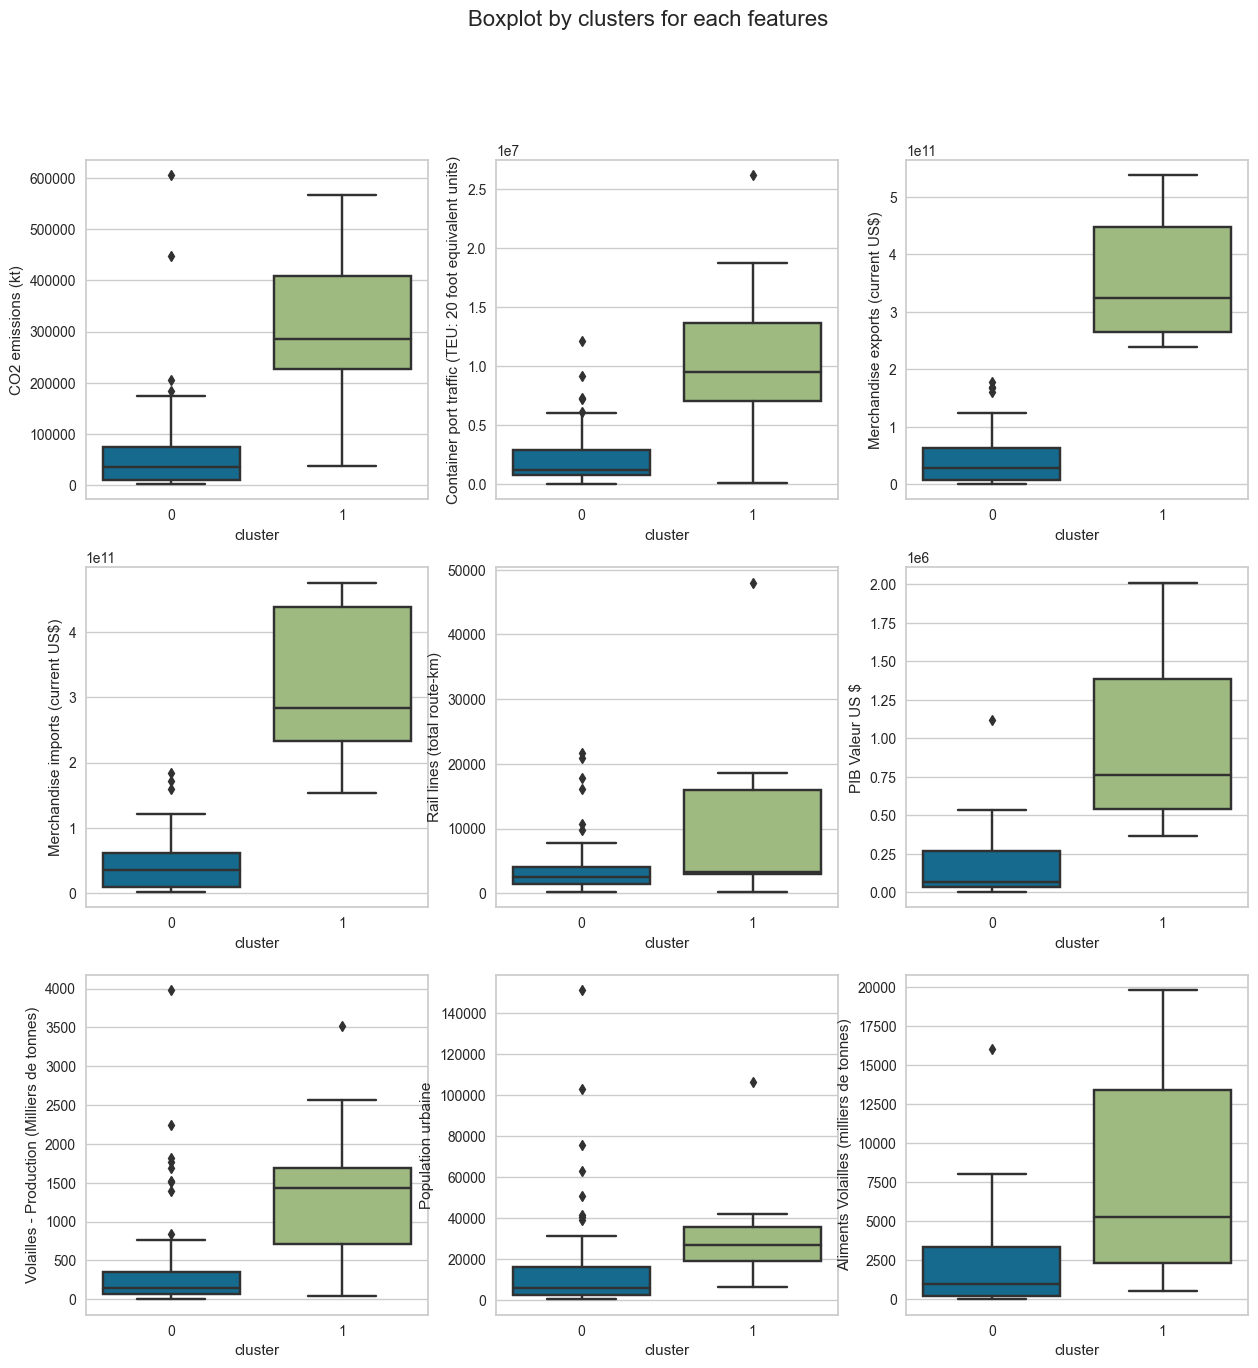

In [81]:
# box plot by clusters for each feature
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="cluster", y="CO2 emissions (kt)", data=km_df, ax=ax[0,0])
sns.boxplot(x="cluster", y="Container port traffic (TEU: 20 foot equivalent units)", data=km_df, ax=ax[0,1])
sns.boxplot(x="cluster", y="Merchandise exports (current US$)", data=km_df, ax=ax[0,2])
sns.boxplot(x="cluster", y="Merchandise imports (current US$)", data=km_df, ax=ax[1,0])
sns.boxplot(x="cluster", y="Rail lines (total route-km)", data=km_df, ax=ax[1,1])
sns.boxplot(x="cluster", y="PIB Valeur US $", data=km_df, ax=ax[1,2])
sns.boxplot(x="cluster", y="Volailles - Production (Milliers de tonnes)", data=km_df, ax=ax[2,0])
sns.boxplot(x="cluster", y="Population urbaine", data=km_df, ax=ax[2,1])
sns.boxplot(x="cluster", y="Aliments Volailles (milliers de tonnes)", data=km_df, ax=ax[2,2])
fig.suptitle('Boxplot by clusters for each features', fontsize=16)

Dans ce cas, le cluster 1 semble être le cluster le plus intéressant sur lequel approffondir une étude de marché.
-Les produits d'alimentation de ce cluster sont plus accessible que le cluster 0 (malgré une énorme variance à ce niveau là)  
-Le PIB par habitant est plus élevé que le cluster 0
-En ce qui concerne les imports/exports, le réseau féroviaire ou le transfet de marchandise par voie maritime, le cluster 1 est au dessus du cluster 0.

Il est aussi intéressant de noter une population plus urbaine dans le cluster 1 et une émission de CO2 élevée.

In [82]:
cluster0 = km_df[km_df['cluster']==0]
cluster0

CO2 emissions (kt)  \
Zone                                    
Afrique du Sud               446626.0   
Algérie                      170582.4   
Argentine                    168162.0   
Arménie                        6195.6   
Autriche                      64497.8   
Azerbaïdjan                   35521.0   
Bangladesh                    92645.0   
Botswana                       7198.3   
Bulgarie                      39159.9   
Burkina Faso                   5646.5   
Cameroun                       9557.3   
Chili                         91915.4   
Colombie                      79186.7   
Croatie                       16523.3   
Danemark                      29696.5   
Finlande                      40987.1   
Gabon                          5274.5   
Grèce                         59990.3   
Géorgie                       10549.6   
Hongrie                       47261.8   
Indonésie                    605290.6   
Irlande                       35812.2   
Israël                        62796.3   
Kazakhstan                   204592.2   
Lettonie                       7569.1   
Lituanie                      11735.8   
Luxembourg                     9500.3   
Macédoine du Nord              7956.1   
Madagascar                     3927.7   
Maroc                         70986.3   
Mauritanie                     3824.8   
Mongolie                      23146.9   
Monténégro                     2601.1   
Nigéria                      119544.1   
Oman                          75744.8   
Ouzbékistan                  117687.8   
Pakistan                     184096.3   
Panama                        13099.9   
Philippines                  145871.3   
Portugal                      44564.7   
Pérou                         56972.2   
Roumanie                      73942.8   
Serbie                        46030.1   
Slovénie                      13665.0   
Soudan                        22131.5   
Sri Lanka                     23427.9   
Suède                         34964.6   
Tadjikistan                    8965.7   
Tunisie                       31045.0   
Ukraine                      174599.9   
Uruguay                        6806.7   
Zambie                         7615.7   
Zimbabwe                      10185.3   

                   Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                        
Afrique du Sud                                            4529034.00        
Algérie                                                   1793990.00        
Argentine                                                 1833964.00        
Arménie                                                   1229081.00        
Autriche                                                  1229081.00        
Azerbaïdjan                                               1229081.00        
Bangladesh                                                3145919.00        
Botswana                                                  1229081.00        
Bulgarie                                                   261934.00        
Burkina Faso                                              1229081.00        
Cameroun                                                   370685.00        
Chili                                                     4647086.00        
Colombie                                                  4316862.00        
Croatie                                                    348435.00        
Danemark                                                   880039.00        
Finlande                                                  1628170.00        
Gabon                                                      192998.00        
Grèce                                                     6153567.00        
Géorgie                                                    601491.00        
Hongrie                                                   1229081.00        
Indonésie                                                12111471.00 

In [83]:
cluster1 = km_df[km_df['cluster']==1]
cluster1

CO2 emissions (kt)  \
Zone                                      
Arabie saoudite                526770.3   
Australie                      395199.1   
Belgique                        92989.4   
Canada                         566001.8   
Espagne                        241886.5   
Italie                         317223.0   
Malaisie                       244882.0   
Mexique                        451828.8   
Pologne                        294948.3   
Suisse                          37376.3   
Thaïlande                      274466.7   
Émirats arabes unis            185645.7   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Arabie saoudite                                              8905621.0        
Australie                                                    8775819.0        
Belgique                                                    12389876.0        
Canada                                                       7000133.0        
Espagne                                                     17464920.0        
Italie                                                      10789337.0        
Malaisie                                                    26215322.0        
Mexique                                                      7113878.0        
Pologne                                                      3046483.0        
Suisse                                                        121366.0        
Thaïlande                                                   10130294.0        
Émirats arabes unis                                         18802000.0        

                     Merchandise exports (current US$)  \
Zone                                                     
Arabie saoudite                           261603000000   
Australie                                 271005000000   
Belgique                                  446910000000   
Canada                                    448817000000   
Espagne                                   334018000000   
Italie                                    537718000000   
Malaisie                                  238195000000   
Mexique                                   460604000000   
Pologne                                   266595000000   
Suisse                                    313934000000   
Thaïlande                                 246269000000   
Émirats arabes unis                       389428000000   

                     Merchandise imports (current US$)  \
Zone                                                     
Arabie saoudite                           153163000000   
Australie                                 221564000000   
Belgique                                  428878000000   
Canada                                    462993000000   
Espagne                                   372750000000   
Italie                                    475006000000   
Malaisie                                  204998000000   
Mexique                                   467118000000   
Pologne                                   265282000000   
Suisse                                    277830000000   
Thaïlande                                 236260000000   
Émirats arabes unis                       288447000000   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Arabie saoudite                      2977.500000     7.929668e+05   
Australie                            2977.500000     1.380208e+06   
Belgique                             3615.000000     5.352887e+05   
Canada                              47987.470000     1.741497e+06   
Espagne                             15718.000000     1.393046e+06   
Italie                              16778.600000     2.009384e+06   
Malaisie                             1655.000000     3.646840e+05   
Mexique                              2977.500000     1.268868e+0

#### Projection des individus sur F1/F2/F3/F4

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


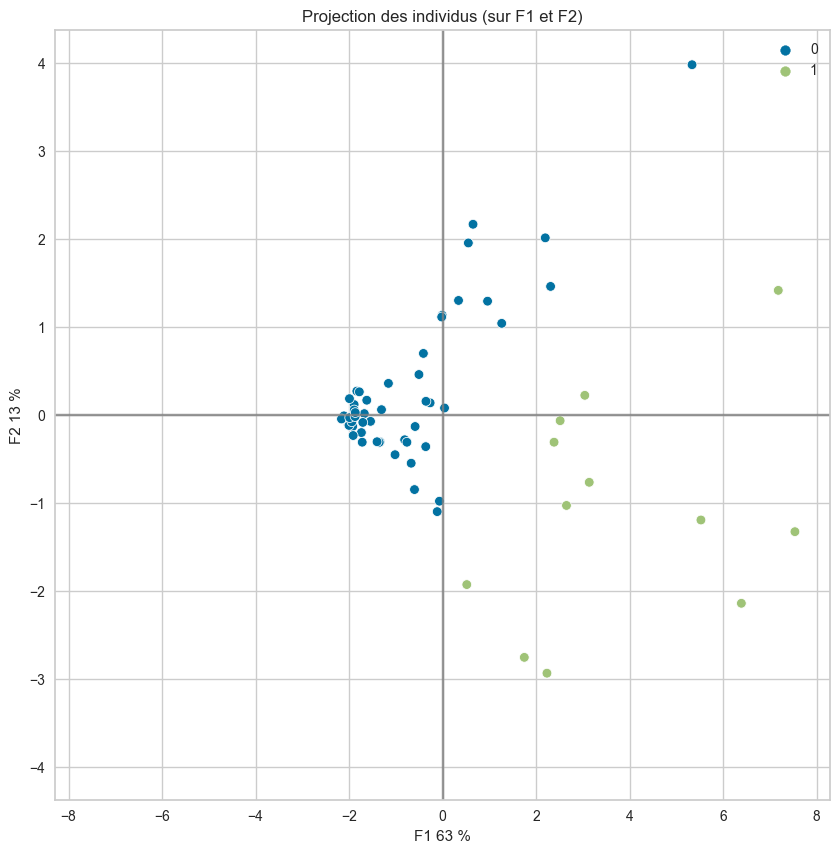

In [84]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


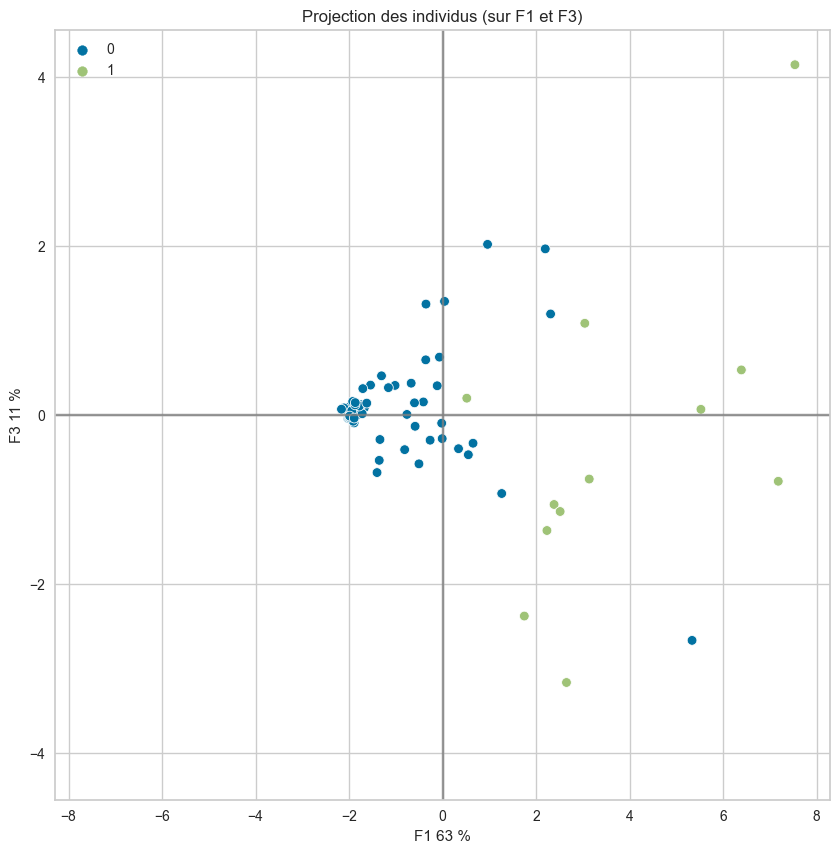

In [85]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,2),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


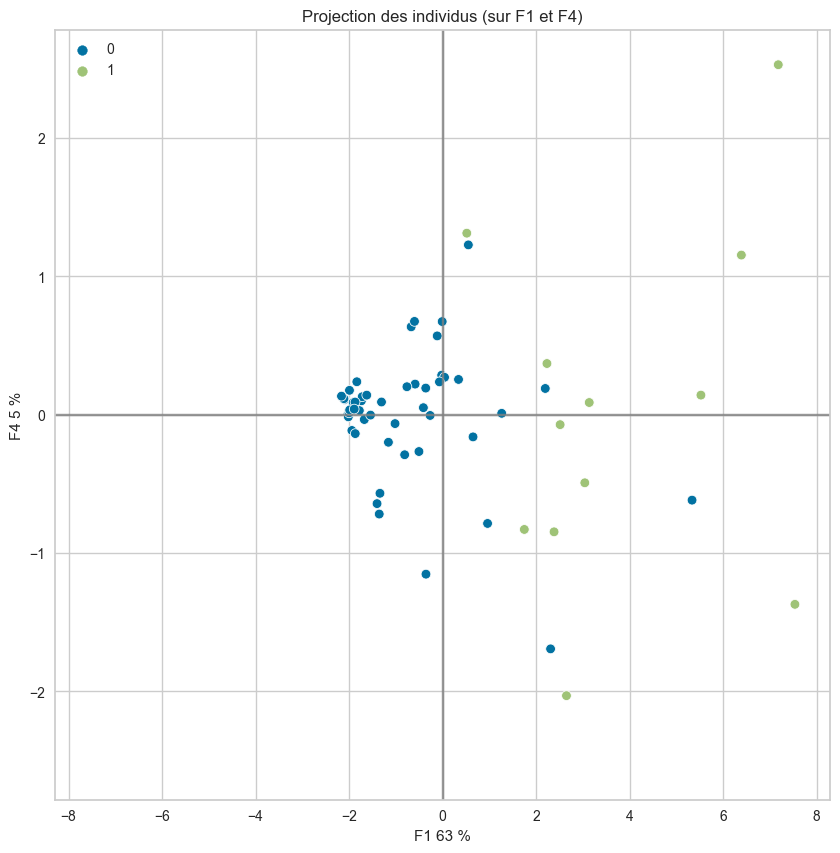

In [86]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,3),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


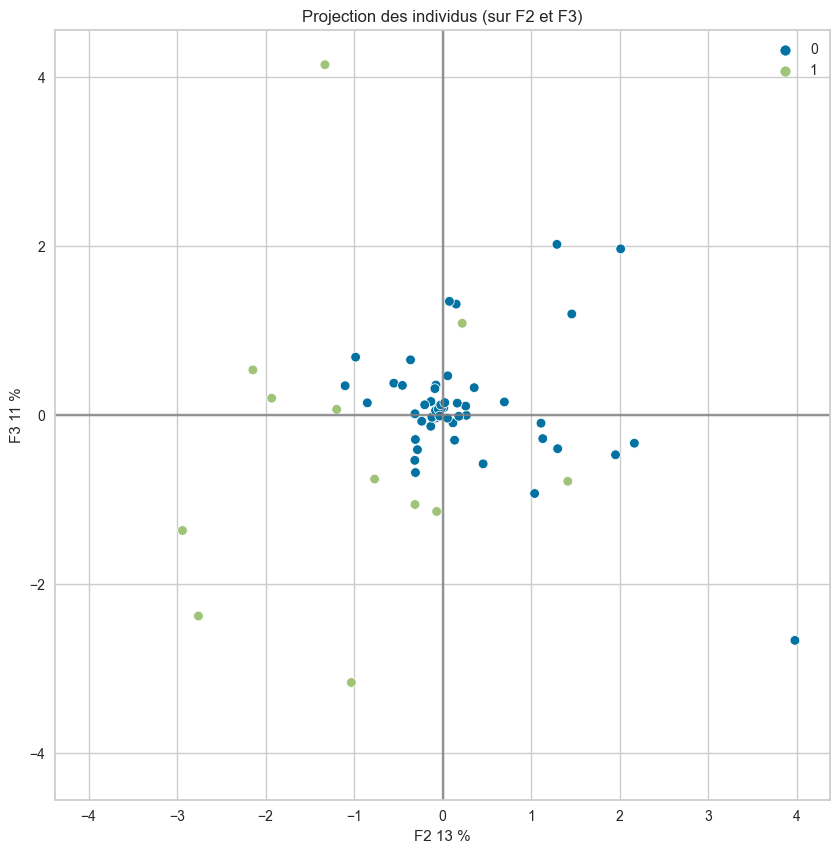

In [87]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,2),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


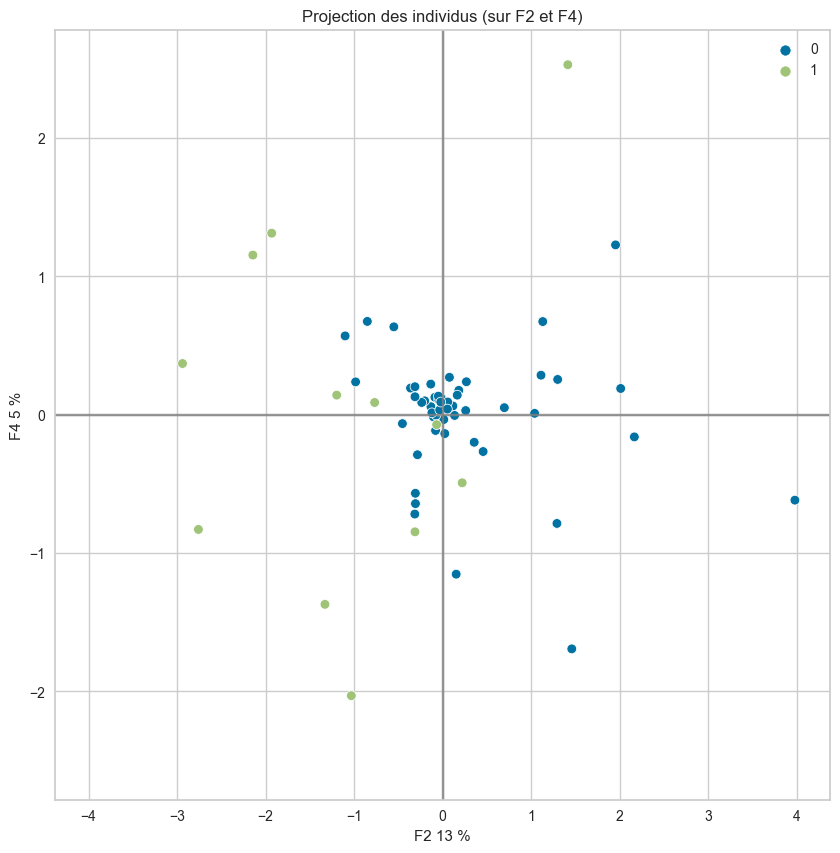

In [88]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,3),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


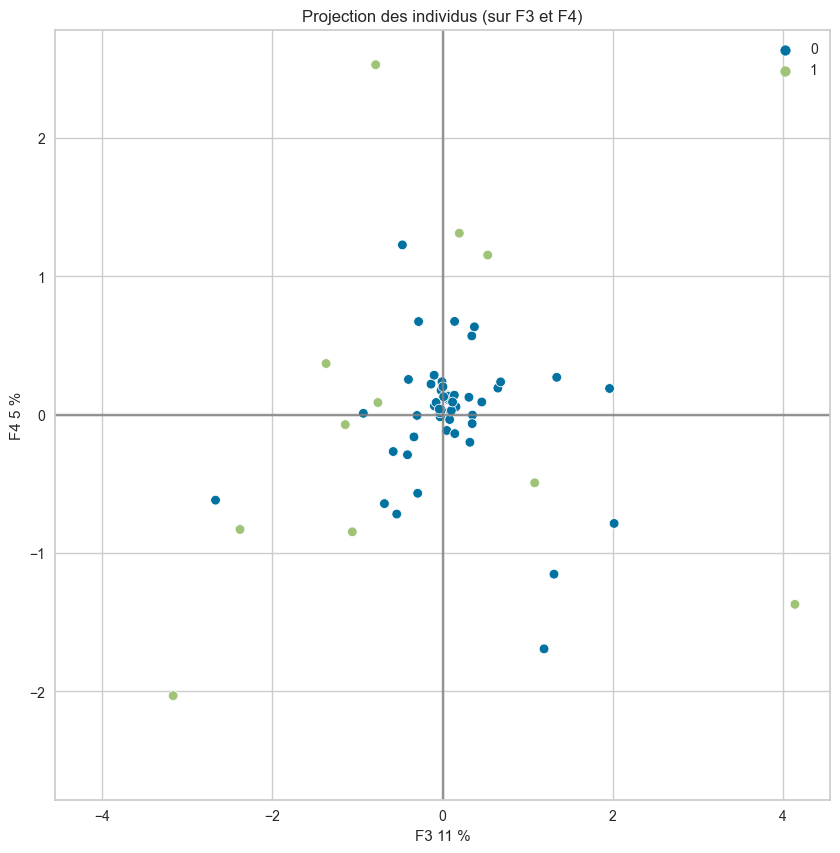

In [89]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(2,3),clusters=km.clusters)

Globalement, le cluster 1 se démarque bien du cluster 0.

# 5 Clusters 

In [90]:
df = df.drop(columns=['cluster'])
km.kmean_choose(5)
km.clusters

array([4, 4, 3, 4, 2, 3, 0, 2, 4, 1, 2, 4, 2, 2, 1, 4, 4, 2, 0, 1, 4, 2,
       4, 2, 0, 0, 0, 4, 1, 4, 2, 4, 2, 2, 2, 3, 4, 2, 1, 2, 2, 4, 2, 2,
       4, 2, 4, 3, 4, 4, 4, 2, 4, 2, 2, 3, 0, 2, 3, 2, 4, 2, 2, 2, 3],
      dtype=int32)

In [91]:
df

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                 446626.0   
Algérie                        170582.4   
Arabie saoudite                526770.3   
Argentine                      168162.0   
Arménie                          6195.6   
...                                 ...   
Ukraine                        174599.9   
Uruguay                          6806.7   
Zambie                           7615.7   
Zimbabwe                        10185.3   
Émirats arabes unis            185645.7   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               4529034.0        
Algérie                                                      1793990.0        
Arabie saoudite                                              8905621.0        
Argentine                                                    1833964.0        
Arménie                                                      1229081.0        
...                                                                ...        
Ukraine                                                      1007273.0        
Uruguay                                                       749562.0        
Zambie                                                       1229081.0        
Zimbabwe                                                     1229081.0        
Émirats arabes unis                                         18802000.0        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                             90016000000   
Algérie                                    35312000000   
Arabie saoudite                           261603000000   
Argentine                                  65116000000   
Arménie                                     2640000000   
...                                                ...   
Ukraine                                    50054000000   
Uruguay                                     7680000000   
Zambie                                      7039000000   
Zimbabwe                                    4269000000   
Émirats arabes unis                       389428000000   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                            107539000000   
Algérie                                    44632000000   
Arabie saoudite                           153163000000   
Argentine                                  49124000000   
Arménie                                     5514000000   
...                                                ...   
Ukraine                                    60800000000   
Uruguay                                     8246000000   
Zambie                                      7173000000   
Zimbabwe                                    4817000000   
Émirats arabes unis                       288447000000   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          20953.00    351430.991183   
Algérie                                  4020.25    171158.234285   
Arabie saoudite                          2977.50    792966.838190   
Argentine                               17866.00    445445.254556   
Arménie                                   698.40     13619.290546   
...                                          ...              ...   
Ukraine                                 21625.90    153929.552493   
Uruguay                                  1498.00     61231.193299   
Zambie                                   1248.00     23309.720448   
Zimbabwe                                 3120.00     21935.075306   
Émirats arabes unis                       261.00    417215.559513   

                     Vola

In [92]:
df['cluster']=km.clusters
columns.append('cluster')

In [93]:
df.columns

Index(['CO2 emissions (kt)',
       'Container port traffic (TEU: 20 foot equivalent units)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)', 'Rail lines (total route-km)',
       'PIB Valeur US $', 'Volailles - Production (Milliers de tonnes)',
       'Population urbaine', 'Aliments Volailles (milliers de tonnes)',
       'cluster'],
      dtype='object')

In [94]:
km_df = df.copy() 

In [95]:
km_df

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                 446626.0   
Algérie                        170582.4   
Arabie saoudite                526770.3   
Argentine                      168162.0   
Arménie                          6195.6   
...                                 ...   
Ukraine                        174599.9   
Uruguay                          6806.7   
Zambie                           7615.7   
Zimbabwe                        10185.3   
Émirats arabes unis            185645.7   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               4529034.0        
Algérie                                                      1793990.0        
Arabie saoudite                                              8905621.0        
Argentine                                                    1833964.0        
Arménie                                                      1229081.0        
...                                                                ...        
Ukraine                                                      1007273.0        
Uruguay                                                       749562.0        
Zambie                                                       1229081.0        
Zimbabwe                                                     1229081.0        
Émirats arabes unis                                         18802000.0        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                             90016000000   
Algérie                                    35312000000   
Arabie saoudite                           261603000000   
Argentine                                  65116000000   
Arménie                                     2640000000   
...                                                ...   
Ukraine                                    50054000000   
Uruguay                                     7680000000   
Zambie                                      7039000000   
Zimbabwe                                    4269000000   
Émirats arabes unis                       389428000000   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                            107539000000   
Algérie                                    44632000000   
Arabie saoudite                           153163000000   
Argentine                                  49124000000   
Arménie                                     5514000000   
...                                                ...   
Ukraine                                    60800000000   
Uruguay                                     8246000000   
Zambie                                      7173000000   
Zimbabwe                                    4817000000   
Émirats arabes unis                       288447000000   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          20953.00    351430.991183   
Algérie                                  4020.25    171158.234285   
Arabie saoudite                          2977.50    792966.838190   
Argentine                               17866.00    445445.254556   
Arménie                                   698.40     13619.290546   
...                                          ...              ...   
Ukraine                                 21625.90    153929.552493   
Uruguay                                  1498.00     61231.193299   
Zambie                                   1248.00     23309.720448   
Zimbabwe                                 3120.00     21935.075306   
Émirats arabes unis                       261.00    417215.559513   

                     Vola

Text(0.5, 0.98, 'Boxplot by clusters for each features')

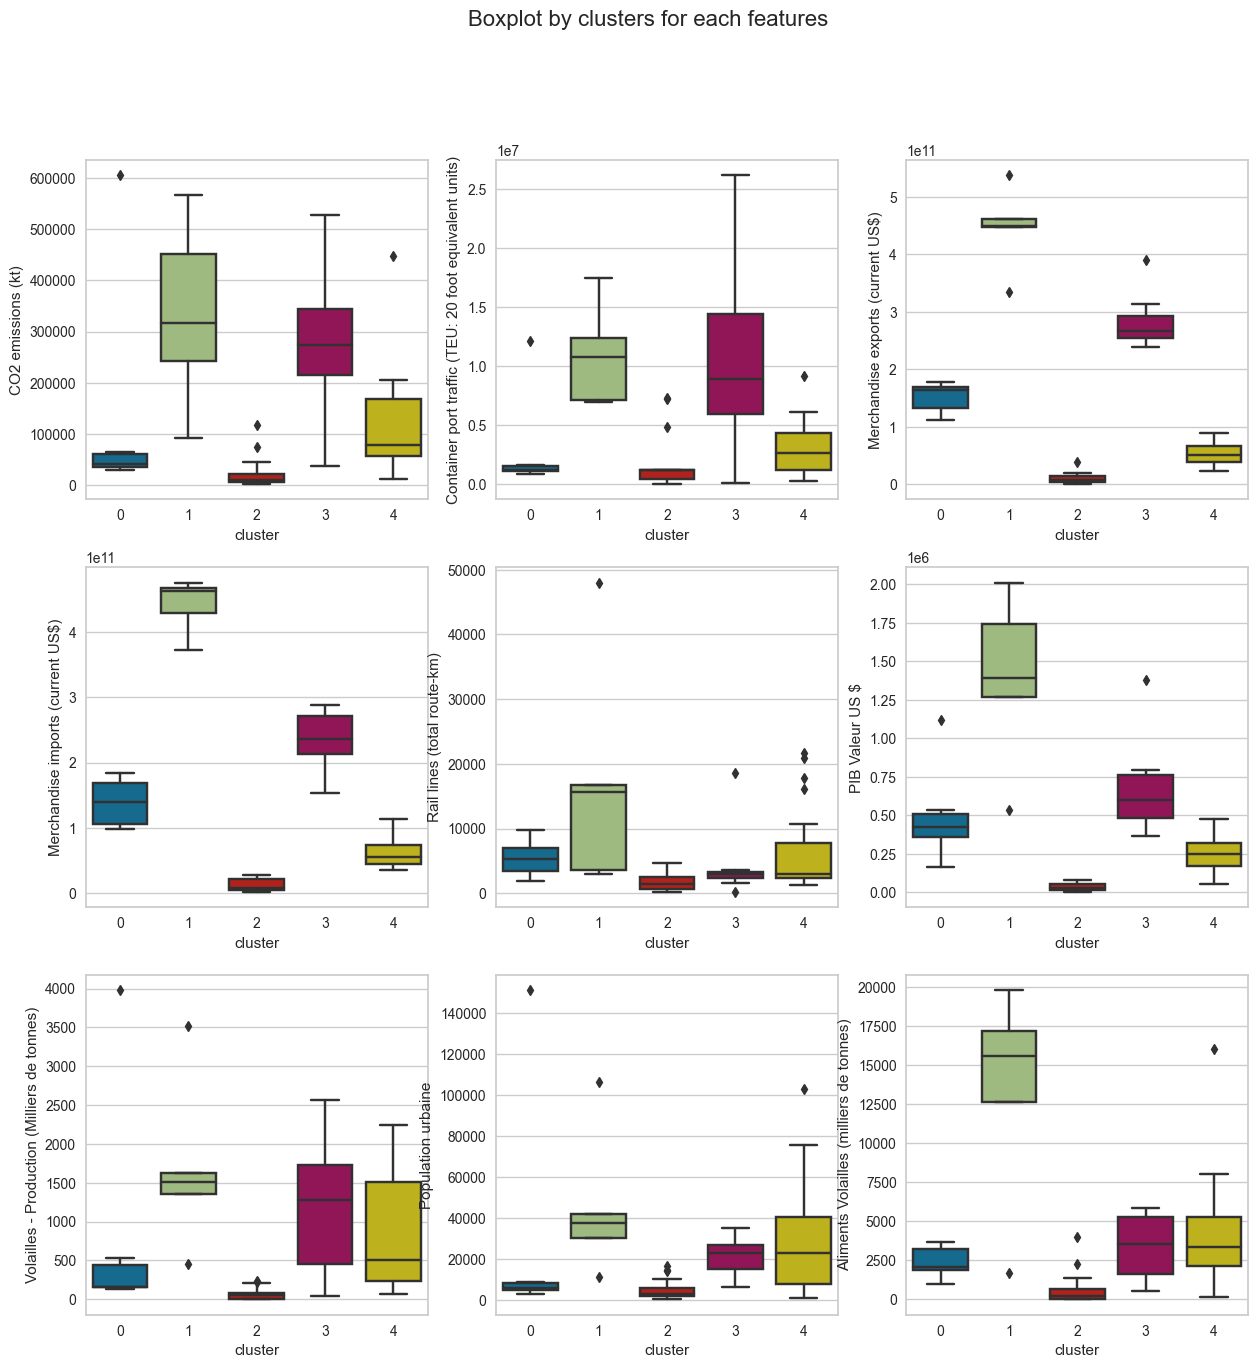

In [96]:
# box plot by clusters for each feature
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="cluster", y="CO2 emissions (kt)", data=km_df, ax=ax[0,0])
sns.boxplot(x="cluster", y="Container port traffic (TEU: 20 foot equivalent units)", data=km_df, ax=ax[0,1])
sns.boxplot(x="cluster", y="Merchandise exports (current US$)", data=km_df, ax=ax[0,2])
sns.boxplot(x="cluster", y="Merchandise imports (current US$)", data=km_df, ax=ax[1,0])
sns.boxplot(x="cluster", y="Rail lines (total route-km)", data=km_df, ax=ax[1,1])
sns.boxplot(x="cluster", y="PIB Valeur US $", data=km_df, ax=ax[1,2])
sns.boxplot(x="cluster", y="Volailles - Production (Milliers de tonnes)", data=km_df, ax=ax[2,0])
sns.boxplot(x="cluster", y="Population urbaine", data=km_df, ax=ax[2,1])
sns.boxplot(x="cluster", y="Aliments Volailles (milliers de tonnes)", data=km_df, ax=ax[2,2])
fig.suptitle('Boxplot by clusters for each features', fontsize=16)

Le cluster 0 possède un production de volaille très modérée. On y voit bien une part non négligeable de l'alimentation réservée à l'élevage. Les import/export sont très élevés. Le réseau féroviaire est très développé et le transport de marchandise par voie maritime est très important. Les imports/exports y sont aussi modérés.

Le cluster 1, de par son PIB important, est un cluster de pays riche. La production de volaille y est très importante avec une variance relativement faible tout. La part de l'alimentation réservée à l'élevage est la plus importante. Les imports/exports sont très élevés. Le réseau féroviaire est développé et le transport de marchandise par voie maritime est très important. On remarque aussi une emission de CO2 importante.

Le cluster 2 est le groupe de pays où l'on retrouve la plus basse production de Volaille. Celui-ci possède une part de Blé et de Maïs réservé à l'élevage qui est très faible. Il y a très peu d'import/exporrtu féroviaire etrès limité et peu de transport de marchandise par voie maritime.


Le cluster 3 et 4 se ressemblent beaucoup si l'on regarde la population urbaine, la production de volaille et la part d'alimentation dédié à lélevage. Il est important de noté que la production de volaille possède une médiane plus élevée sur le cluster 3. Sur cette même variable, on remarque une variance assez importante. Là où le cluster 3 se diférencie du 4, c'est sur la richesse des pays qui le compose : il possède un PIB plus élevé, et naturellement celà s'impact sur plus d'export, plus d'import, nottament par voie maritime et une émission de CO2 importante. Sans regarder les pays qui le composent, on peut imaginer des pays en voie de développement.
Si on omet le cluster 2, on remarque que le cluster 4 est composé des pays les plus pauvres.

In [97]:
cluster0 = km_df[km_df['cluster']==0]
cluster1 = km_df[km_df['cluster']==1]
cluster2 = km_df[km_df['cluster']==2]
cluster3 = km_df[km_df['cluster']==3]
cluster4 = km_df[km_df['cluster']==4]

In [98]:
cluster0

CO2 emissions (kt)  \
Zone                            
Autriche              64497.8   
Danemark              29696.5   
Hongrie               47261.8   
Indonésie            605290.6   
Irlande               35812.2   
Suède                 34964.6   

           Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                
Autriche                                           1229081.0        
Danemark                                            880039.0        
Hongrie                                            1229081.0        
Indonésie                                         12111471.0        
Irlande                                            1063489.0        
Suède                                              1623363.0        

           Merchandise exports (current US$)  \
Zone                                           
Autriche                        178670000000   
Danemark                        111076000000   
Hongrie                         123796000000   
Indonésie                       167683000000   
Irlande                         169625000000   
Suède                           160576000000   

           Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                        
Autriche                        184758000000                       4968.0   
Danemark                         98184000000                       2977.5   
Hongrie                         120590000000                       7587.7   
Indonésie                       171276000000                       5483.0   
Irlande                         101104000000                       1888.0   
Suède                           158971000000                       9701.0   

           PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                      
Autriche      4.450119e+05                                        132.0   
Danemark      3.475613e+05                                        158.0   
Hongrie       1.635265e+05                                        532.0   
Indonésie     1.119091e+06                                       3975.0   
Irlande       3.991221e+05                                        154.0   
Suède         5.338795e+05                                        158.0   

           Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                     
Autriche             5129.574                                   1828.0   
Danemark             5081.840                                   3639.0   
Hongrie              6917.508                                   3511.0   
Indonésie          150900.390                                   1894.0   
Irlande              3073.341                                   2235.0   
Suède                8817.415                                   1011.0   

           cluster  
Zone                
Autriche         0  
Danemark         0  
Hongrie          0  
Indonésie        0  
Irlande          0  
Suède            0

Il est intéressant ici de remarquer qu'hormis l'Indonésie, nous n'avons dans ce cluster que des pays appertenant à l'U.E. Si ces pays ne produisent pas beaucoup de volaille, peut-être est-il possible d'en exporter ! Le fait que ces pays apprtiennent à l'U.E pourrait-être un avantage pour l'exportation.

In [99]:
cluster1

CO2 emissions (kt)  \
Zone                           
Belgique             92989.4   
Canada              566001.8   
Espagne             241886.5   
Italie              317223.0   
Mexique             451828.8   

          Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                               
Belgique                                         12389876.0        
Canada                                            7000133.0        
Espagne                                          17464920.0        
Italie                                           10789337.0        
Mexique                                           7113878.0        

          Merchandise exports (current US$)  \
Zone                                          
Belgique                       446910000000   
Canada                         448817000000   
Espagne                        334018000000   
Italie                         537718000000   
Mexique                        460604000000   

          Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                       
Belgique                       428878000000                      3615.00   
Canada                         462993000000                     47987.47   
Espagne                        372750000000                     15718.00   
Italie                         475006000000                     16778.60   
Mexique                        467118000000                      2977.50   

          PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                     
Belgique     5.352887e+05                                        448.0   
Canada       1.741497e+06                                       1506.0   
Espagne      1.393046e+06                                       1631.0   
Italie       2.009384e+06                                       1358.0   
Mexique      1.268868e+06                                       3515.0   

          Population urbaine  Aliments Volailles (milliers de tonnes)  cluster  
Zone                                                                            
Belgique           11336.228                                   1680.0        1  
Canada             30376.281                                  15546.0        1  
Espagne            37415.111                                  17195.0        1  
Italie             41887.345                                  12655.0        1  
Mexique           106450.227                                  19767.0        1

Nous pouvons remarqué que sur le cluster 1, nous retrouvons l'Espagne, l'Italie et le Mexique. Ces pays appartenaient au troisième cluster de notre CAH.
Si l'on regarde la production de volaille dans ces pays, nous pouvons y voir une variance très faible. Ceci est un avantage non négligeable. Si la production est stable, il est plus facile de prévoir le besoin de matière première pour la production de volaille (le blé et le Maîs). Il est aussi plus facile de prévoir les ventes de volaille.

In [100]:
cluster2

CO2 emissions (kt)  \
Zone                                    
Arménie                        6195.6   
Azerbaïdjan                   35521.0   
Botswana                       7198.3   
Burkina Faso                   5646.5   
Cameroun                       9557.3   
Croatie                       16523.3   
Gabon                          5274.5   
Géorgie                       10549.6   
Lettonie                       7569.1   
Luxembourg                     9500.3   
Macédoine du Nord              7956.1   
Madagascar                     3927.7   
Mauritanie                     3824.8   
Mongolie                      23146.9   
Monténégro                     2601.1   
Oman                          75744.8   
Ouzbékistan                  117687.8   
Panama                        13099.9   
Serbie                        46030.1   
Soudan                        22131.5   
Sri Lanka                     23427.9   
Tadjikistan                    8965.7   
Tunisie                       31045.0   
Uruguay                        6806.7   
Zambie                         7615.7   
Zimbabwe                      10185.3   

                   Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                        
Arménie                                                   1229081.00        
Azerbaïdjan                                               1229081.00        
Botswana                                                  1229081.00        
Burkina Faso                                              1229081.00        
Cameroun                                                   370685.00        
Croatie                                                    348435.00        
Gabon                                                      192998.00        
Géorgie                                                    601491.00        
Lettonie                                                   449850.00        
Luxembourg                                                1229081.00        
Macédoine du Nord                                         1229081.00        
Madagascar                                                 199712.50        
Mauritanie                                                  84457.99        
Mongolie                                                  1229081.00        
Monténégro                                                  15744.41        
Oman                                                      4890471.00        
Ouzbékistan                                               1229081.00        
Panama                                                    7346859.00        
Serbie                                                    1229081.00        
Soudan                                                     469526.00        
Sri Lanka                                                 7230000.00        
Tadjikistan                                               1229081.00        
Tunisie                                                    474222.00        
Uruguay                                                    749562.00        
Zambie                                                    1229081.00        
Zimbabwe                                                  1229081.00        

                   Merchandise exports (current US$)  \
Zone                                                   
Arménie                                   2640000000   
Azerbaïdjan                              19635000000   
Botswana                                  5237000000   
Burkina Faso                              3239000000   
Cameroun                                  4084000000   
Croatie                                  17180000000   
Gabon                                     6722000000   
Géorgie                                   3798000000   
Lettonie                                 15705000000   
Luxembourg                               16451000000   
Macédoine du Nord                        

Le cluster 2 est le moins intéressant à mon sens. Il est composé de beaucoup de pays et comme vue précédemment, il produit peu de volaille, importe peu, exporte peu.

In [101]:
cluster3

CO2 emissions (kt)  \
Zone                                      
Arabie saoudite                526770.3   
Australie                      395199.1   
Malaisie                       244882.0   
Pologne                        294948.3   
Suisse                          37376.3   
Thaïlande                      274466.7   
Émirats arabes unis            185645.7   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Arabie saoudite                                              8905621.0        
Australie                                                    8775819.0        
Malaisie                                                    26215322.0        
Pologne                                                      3046483.0        
Suisse                                                        121366.0        
Thaïlande                                                   10130294.0        
Émirats arabes unis                                         18802000.0        

                     Merchandise exports (current US$)  \
Zone                                                     
Arabie saoudite                           261603000000   
Australie                                 271005000000   
Malaisie                                  238195000000   
Pologne                                   266595000000   
Suisse                                    313934000000   
Thaïlande                                 246269000000   
Émirats arabes unis                       389428000000   

                     Merchandise imports (current US$)  \
Zone                                                     
Arabie saoudite                           153163000000   
Australie                                 221564000000   
Malaisie                                  204998000000   
Pologne                                   265282000000   
Suisse                                    277830000000   
Thaïlande                                 236260000000   
Émirats arabes unis                       288447000000   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Arabie saoudite                      2977.500000     7.929668e+05   
Australie                            2977.500000     1.380208e+06   
Malaisie                             1655.000000     3.646840e+05   
Pologne                             18538.000000     5.972845e+05   
Suisse                               3647.245487     7.317185e+05   
Thaïlande                            2977.500000     5.442637e+05   
Émirats arabes unis                   261.000000     4.172156e+05   

                     Volailles - Production (Milliers de tonnes)  \
Zone                                                               
Arabie saoudite                                            800.0   
Australie                                                 1276.0   
Malaisie                                                  1655.0   
Pologne                                                   2568.0   
Suisse                                                     100.0   
Thaïlande                                                 1804.0   
Émirats arabes unis                                         45.0   

                     Population urbaine  \
Zone                                      
Arabie saoudite               28700.362   
Australie                     21607.414   
Malaisie                      24862.312   
Pologne                       22831.097   
Suisse                         6357.099   
Thaïlande                     35132.892   
Émirats arabes unis            8402.990   

                     Aliments Volailles (milliers de tonnes)  cluster  
Zone                                                                   
Arabie saoudite                                       2511.0        3  
Australie                           

In [102]:
cluster4

CO2 emissions (kt)  \
Zone                                 
Afrique du Sud            446626.0   
Algérie                   170582.4   
Argentine                 168162.0   
Bangladesh                 92645.0   
Bulgarie                   39159.9   
Chili                      91915.4   
Colombie                   79186.7   
Finlande                   40987.1   
Grèce                      59990.3   
Israël                     62796.3   
Kazakhstan                204592.2   
Lituanie                   11735.8   
Maroc                      70986.3   
Nigéria                   119544.1   
Pakistan                  184096.3   
Philippines               145871.3   
Portugal                   44564.7   
Pérou                      56972.2   
Roumanie                   73942.8   
Slovénie                   13665.0   
Ukraine                   174599.9   

                Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                     
Afrique du Sud                                          4529034.0        
Algérie                                                 1793990.0        
Argentine                                               1833964.0        
Bangladesh                                              3145919.0        
Bulgarie                                                 261934.0        
Chili                                                   4647086.0        
Colombie                                                4316862.0        
Finlande                                                1628170.0        
Grèce                                                   6153567.0        
Israël                                                  2917000.0        
Kazakhstan                                              1229081.0        
Lituanie                                                 703000.0        
Maroc                                                   6068803.0        
Nigéria                                                 1627142.0        
Pakistan                                                3150000.0        
Philippines                                             9171944.0        
Portugal                                                2904086.0        
Pérou                                                   2677239.0        
Roumanie                                                 666036.0        
Slovénie                                                 959000.0        
Ukraine                                                 1007273.0        

                Merchandise exports (current US$)  \
Zone                                                
Afrique du Sud                        90016000000   
Algérie                               35312000000   
Argentine                             65116000000   
Bangladesh                            39337000000   
Bulgarie                              33340000000   
Chili                                 68794000000   
Colombie                              39489000000   
Finlande                              73468000000   
Grèce                                 37907000000   
Israël                                58507000000   
Kazakhstan                            57309000000   
Lituanie                              33151000000   
Maroc                                 29132000000   
Nigéria                               62531000000   
Pakistan                              23329000000   
Philippines                           70334000000   
Portugal                              67063000000   
Pérou                                 46444000000   
Roumanie                              76871000000   
Slovénie                              44943000000   
Ukraine                               50054000000   

                Merchandise imports (current US$)  \
Zone                                                
Afrique du Sud                       107539000000   
Algérie                               44632000000   
Argent

#### Projection des individus sur F1/F2/F3/F4

In [103]:
sns.color_palette()
sns.set_palette("bright")

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


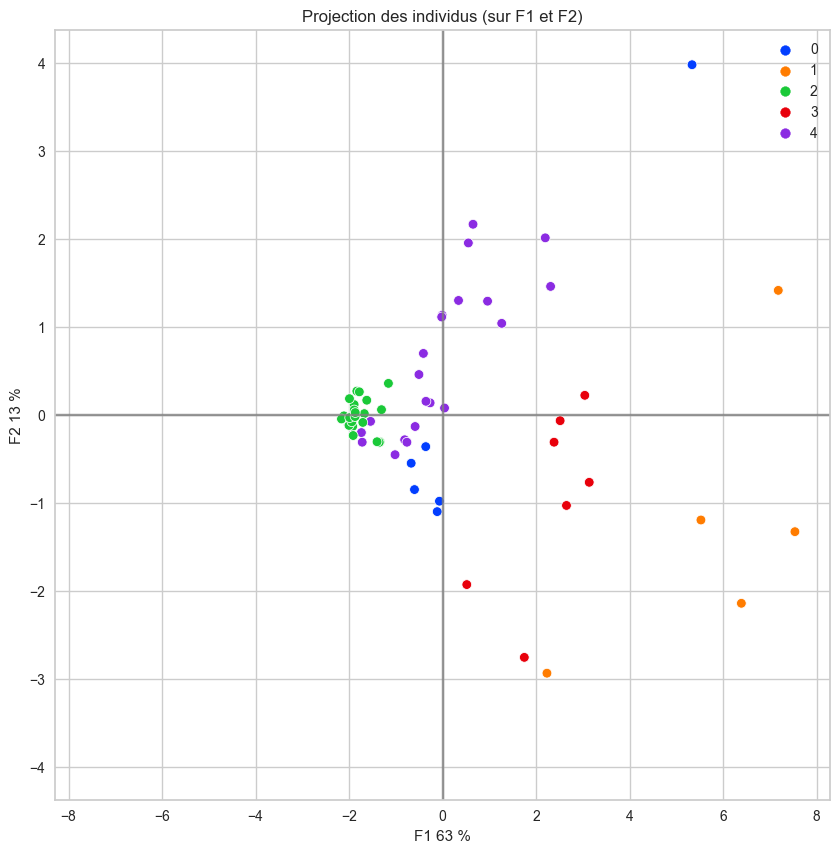

In [104]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


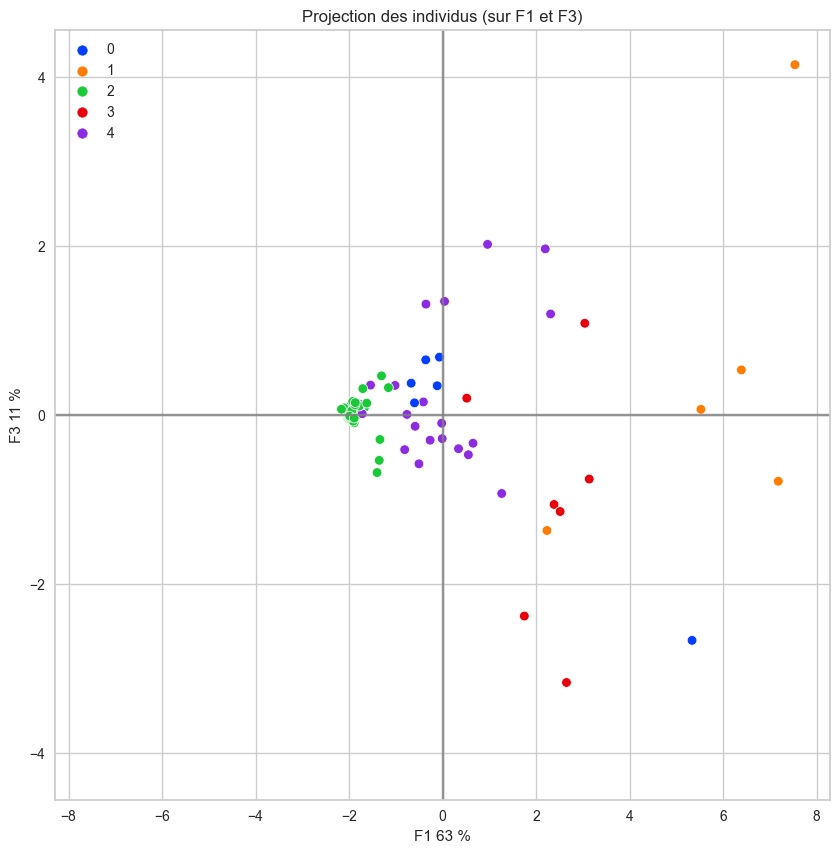

In [105]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,2),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


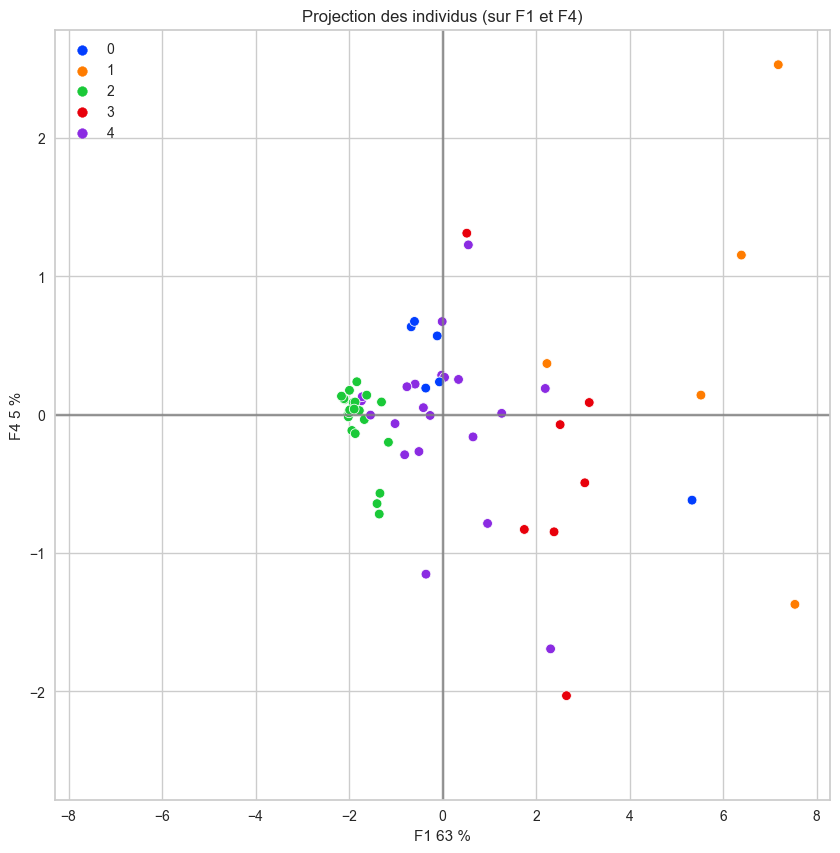

In [106]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,3),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


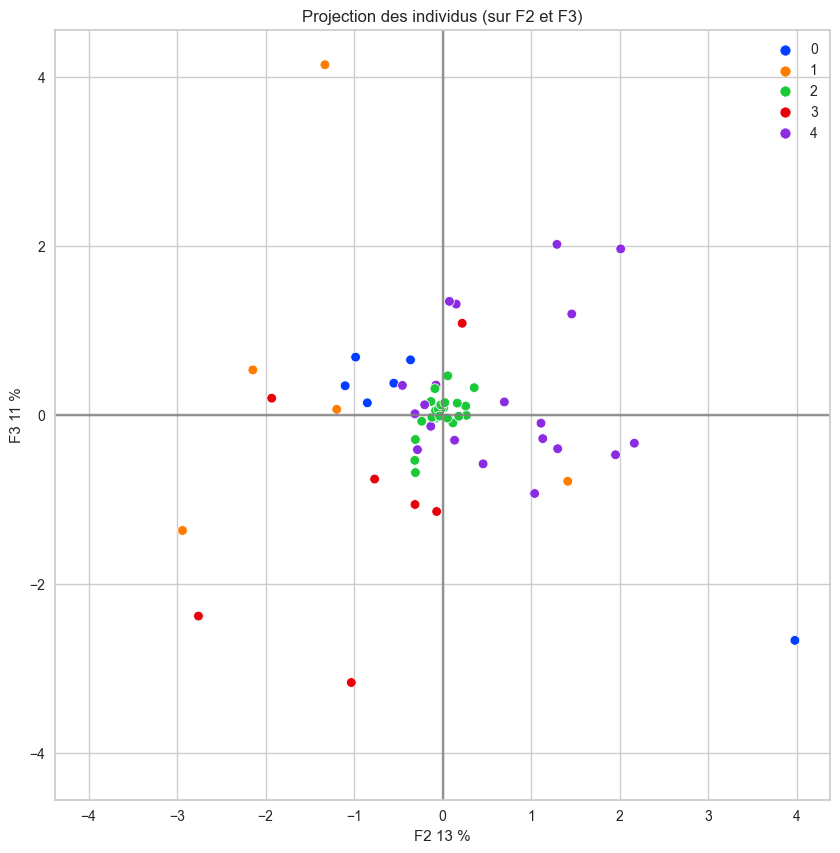

In [107]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,2),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


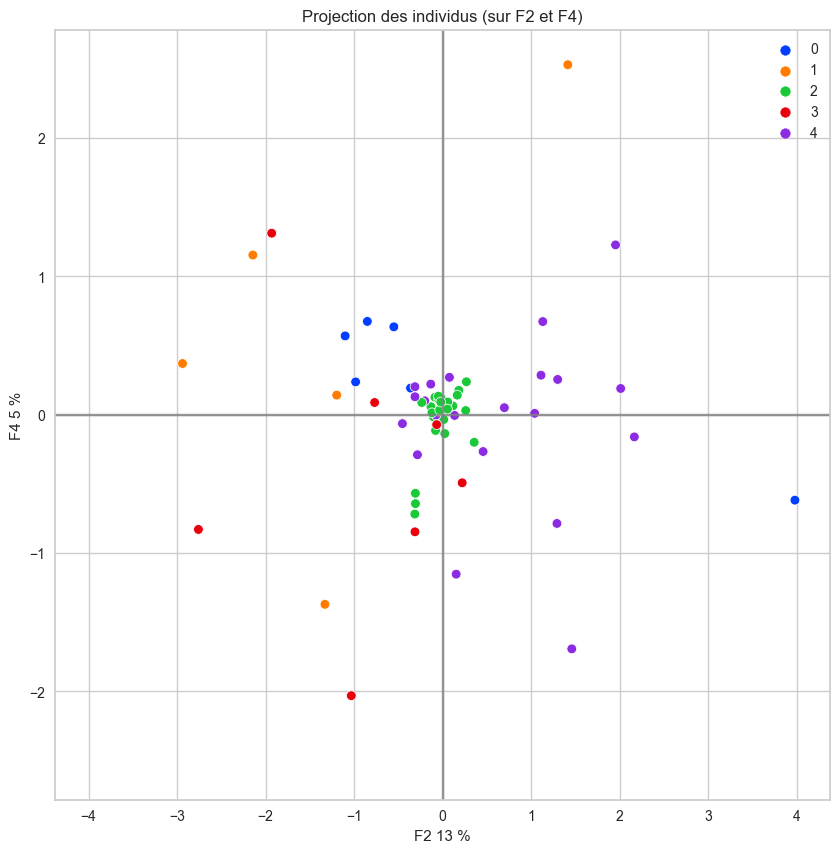

In [108]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,3),clusters=km.clusters)

/tmp/ipykernel_2240868/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


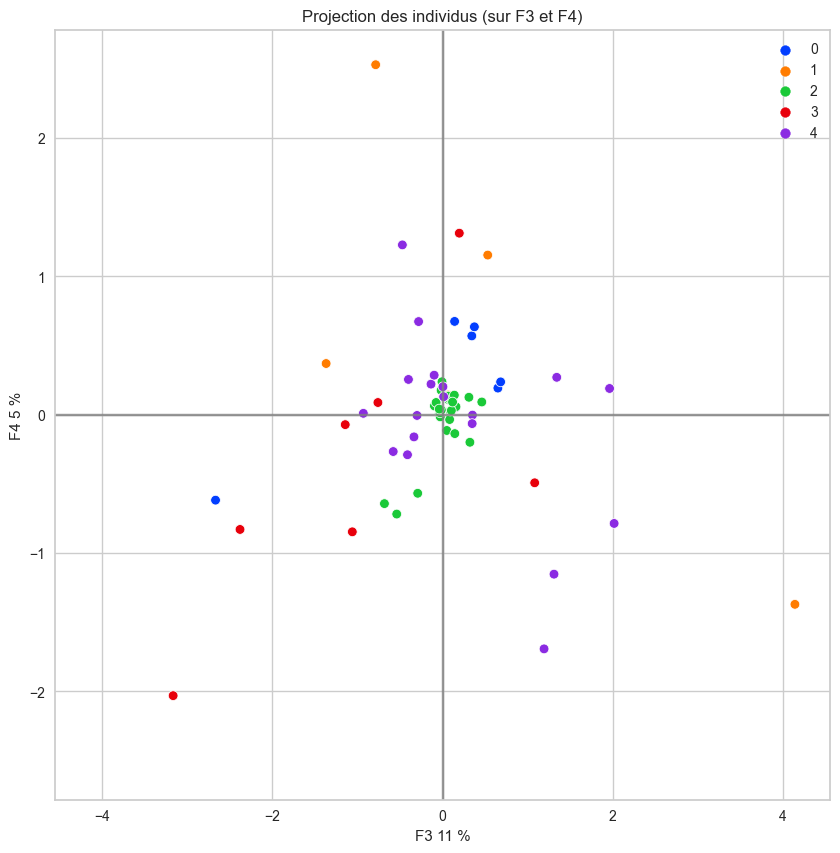

In [109]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(2,3),clusters=km.clusters)

On remarque une distinction notable sur F1/F2, F1/F3 et F1/F4. Les groupes sont moins flaggrants sur les autres associations de dimensions.

# Conclustion
Les cluster 0 et 1 sont pour moi très intéressant à étudier. Le cluster 0 de part ses pays appartenant à l'U.E et le cluster 1 de part sa richesse et sa production de volaille stable.

Le cluster 2 est le moins intéressant. En ce qui concerne les deux derniers clusters, ils possèdent une variance importante sur la production de volaille. Il est donc plus difficile de prévoir la production de volaille et donc les besoins en matière première.